In [32]:
# include all top level packages
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from fem.plots import format_for_paper
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# setup format
format_for_paper()

In [33]:
    # # Return results
    # return {
    #     "kappa_true": true_kappa, # true kappa
    #     "kappa_recovered": kappa_recovered, # recovered kappa
    #     "kappa_final_rel_error": kappa_final_rel_l2_error, # relative L2 error in kappa
    #     "ukappa_true": ukappa, # true solution
    #     "ukappa_measured": u_meas, # measured solution
    #     "ukappa_recovered": u_recovered, # recovered solution
    #     # --- Final Errors ---
    #     "ukappa_recovered_rel_error": u_error_final_rel_l2, # relative L2 error in recovered solution and true solution
    #     "ukappa_recovered_rel_error_meas": u_error_final_rel_l2_meas, # relative L2 error in recovered solution and measured solution
    #     # --- Iterate Errors ---
    #     "ukappa_iterates_error": u_kappa_l2_errors, # L2 error in recovered solution and true solution at each iteration
    #     "ukappa_iterates_error_meas": u_meas_l2_errors, # L2 error in recovered solution and measured solution at each iteration 
    #     "ukappa_iterates_rel_errors": u_kappa_rel_l2_errors, # relative L2 error in recovered solution and true solution at each iteration
    #     "ukappa_iterates_errors": u_kappa_l2_errors, # L2 error in recovered solution and true solution at each iteration
    #     "ukappa_iterates_rel_errors_meas": u_meas_rel_l2_errors, # relative L2 error in recovered solution and measured solution at each iteration
    #     "ukappa_iterates_errors_meas": u_meas_l2_errors, # L2 error in recovered solution and measured solution at each iteration
    #     "kappa_iterates_rel_errors": kappa_rel_l2_errors, # relative L2 error in kappa at each iteration
    #     # --- Iteration Metrics ---
    #     "iterations": len(iterations), # number of iterations
    #     "total_optimization_time": total_optimization_time, # total optimization time
    #     "objectives": objectives, # objective values at each iteration
    #     "reg_values": reg_values, # regularization values at each iteration
    #     "best_reg_value": best_reg_value, # best regularization value
    # }

In [34]:
# load npz file
results = np.load("../results/analysis/results-denoiser-1e-5.npz", allow_pickle=True)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# results = { '107': np.array({'iterations': 89, ...}, dtype=object), ... }

run_keys = list(results.keys())
num_runs = len(run_keys)

# --- 1. Data Extraction with Padding ---

iterative_metrics = [
    "kappa_iterates_rel_errors",
    "ukappa_iterates_rel_errors",
    "ukappa_iterates_rel_errors_meas",
    "objectives",
    "reg_values", # Added reg_values 
]
final_metrics = [
    "kappa_final_rel_error",
    "ukappa_recovered_rel_error",
    "ukappa_recovered_rel_error_meas",
    "total_optimization_time",
    "iterations",
]

extracted_iterative = {metric: [] for metric in iterative_metrics}
extracted_final = {metric: [] for metric in final_metrics}
all_iteration_counts = []

# First pass: Extract data and find max iterations
max_iterations = 0
for key in run_keys:
    try:
        # Use .item() to get the dictionary from the numpy scalar object
        run_data = results[key].item()
        if not isinstance(run_data, dict):
            print(f"Warning: Item for key {key} is not a dict, skipping run.")
            continue

        # Store actual iteration count for this run
        iterations_this_run = run_data.get("iterations")
        # Also check length of an iterative list as a fallback/consistency check
        iter_list_len = len(run_data.get("kappa_iterates_rel_errors", []))

        if iterations_this_run is None:
             iterations_this_run = iter_list_len # Fallback if 'iterations' key missing
             if iter_list_len == 0 and "objectives" in run_data: # Another fallback
                 iterations_this_run = len(run_data.get("objectives", []))

        if iterations_this_run is not None and iterations_this_run > 0:
            all_iteration_counts.append(iterations_this_run)
            max_iterations = max(max_iterations, iterations_this_run)
        else:
             print(f"Warning: Could not determine iteration count for run {key}. Skipping.")
             continue # Skip run if we can't determine iterations

        # Store iterative data for now (will pad later)
        for metric in iterative_metrics:
            if metric in run_data:
                extracted_iterative[metric].append(list(run_data[metric])) # Store as list for now
            else:
                # Placeholder indicating metric was missing for this run
                extracted_iterative[metric].append(None)

        # Store final data
        for metric in final_metrics:
            if metric in run_data:
                extracted_final[metric].append(run_data[metric])
            else:
                extracted_final[metric].append(np.nan)

    except Exception as e:
        print(f"Error processing run {key}: {e}. Skipping run.")
        # Ensure lists in extracted_iterative maintain correspondence if skipping
        for metric in iterative_metrics:
             # Check if we already added placeholder/data for this key in this loop iteration
             if len(extracted_iterative.get(metric, [])) < len(all_iteration_counts) + (1 if 'iterations_this_run' in locals() and iterations_this_run is not None and iterations_this_run>0 else 0) :
                  extracted_iterative[metric].append(None) # Add placeholder if needed


# Check if we found any valid runs
if max_iterations == 0:
    print("Error: No valid runs found or max_iterations is zero. Cannot proceed with plotting.")
else:
    print(f"Found {len(all_iteration_counts)} runs with valid iteration counts. Max iterations: {max_iterations}")
    iterations_axis = np.arange(1, max_iterations + 1)

    # Second pass: Pad iterative data and convert to numpy arrays
    padded_iterative_arrays = {}
    for metric in iterative_metrics:
        padded_data = []
        run_index = 0 # Keep track of which run we are processing
        for i, data_list in enumerate(extracted_iterative[metric]):
             # Find corresponding iteration count for this run's data
             # This assumes the order in extracted_iterative[metric] matches the order runs were successfully processed in the first loop
             if data_list is not None: # Check if metric existed for this run
                 current_run_iterations = all_iteration_counts[run_index]
                 # Pad with NaNs if shorter than max_iterations
                 padding_needed = max_iterations - current_run_iterations
                 if padding_needed > 0:
                      padded_list = data_list + [np.nan] * padding_needed
                 else:
                      # Truncate if longer (shouldn't happen if max_iterations is correct, but safe)
                      padded_list = data_list[:max_iterations]

                 # Ensure final list has exactly max_iterations length
                 if len(padded_list) != max_iterations:
                      # This might happen if data_list was unexpectedly longer than 'iterations' reported
                      print(f"Warning: Length mismatch for metric '{metric}' in run {run_keys[i]}. Adjusting length.")
                      if len(padded_list) > max_iterations:
                          padded_list = padded_list[:max_iterations]
                      else: # Pad if still too short
                          padded_list = padded_list + [np.nan] * (max_iterations - len(padded_list))

                 padded_data.append(padded_list)
                 run_index += 1
             else:
                 # If metric was missing for the run, add a list of NaNs
                 padded_data.append([np.nan] * max_iterations)
                 # We still need to increment run_index IF the run itself was valid (had iterations)
                 # Check if the overall index 'i' corresponds to a valid run index
                 if i < len(all_iteration_counts): # Safety check
                      run_index += 1


        if padded_data: # Only add if we collected some data
             padded_iterative_arrays[metric] = np.array(padded_data, dtype=np.float64) # Use float64 for NaNs

Found 100 runs with valid iteration counts. Max iterations: 695


Saving figure to ../figures/denoiser-1e-5/solution_error_true.pdf


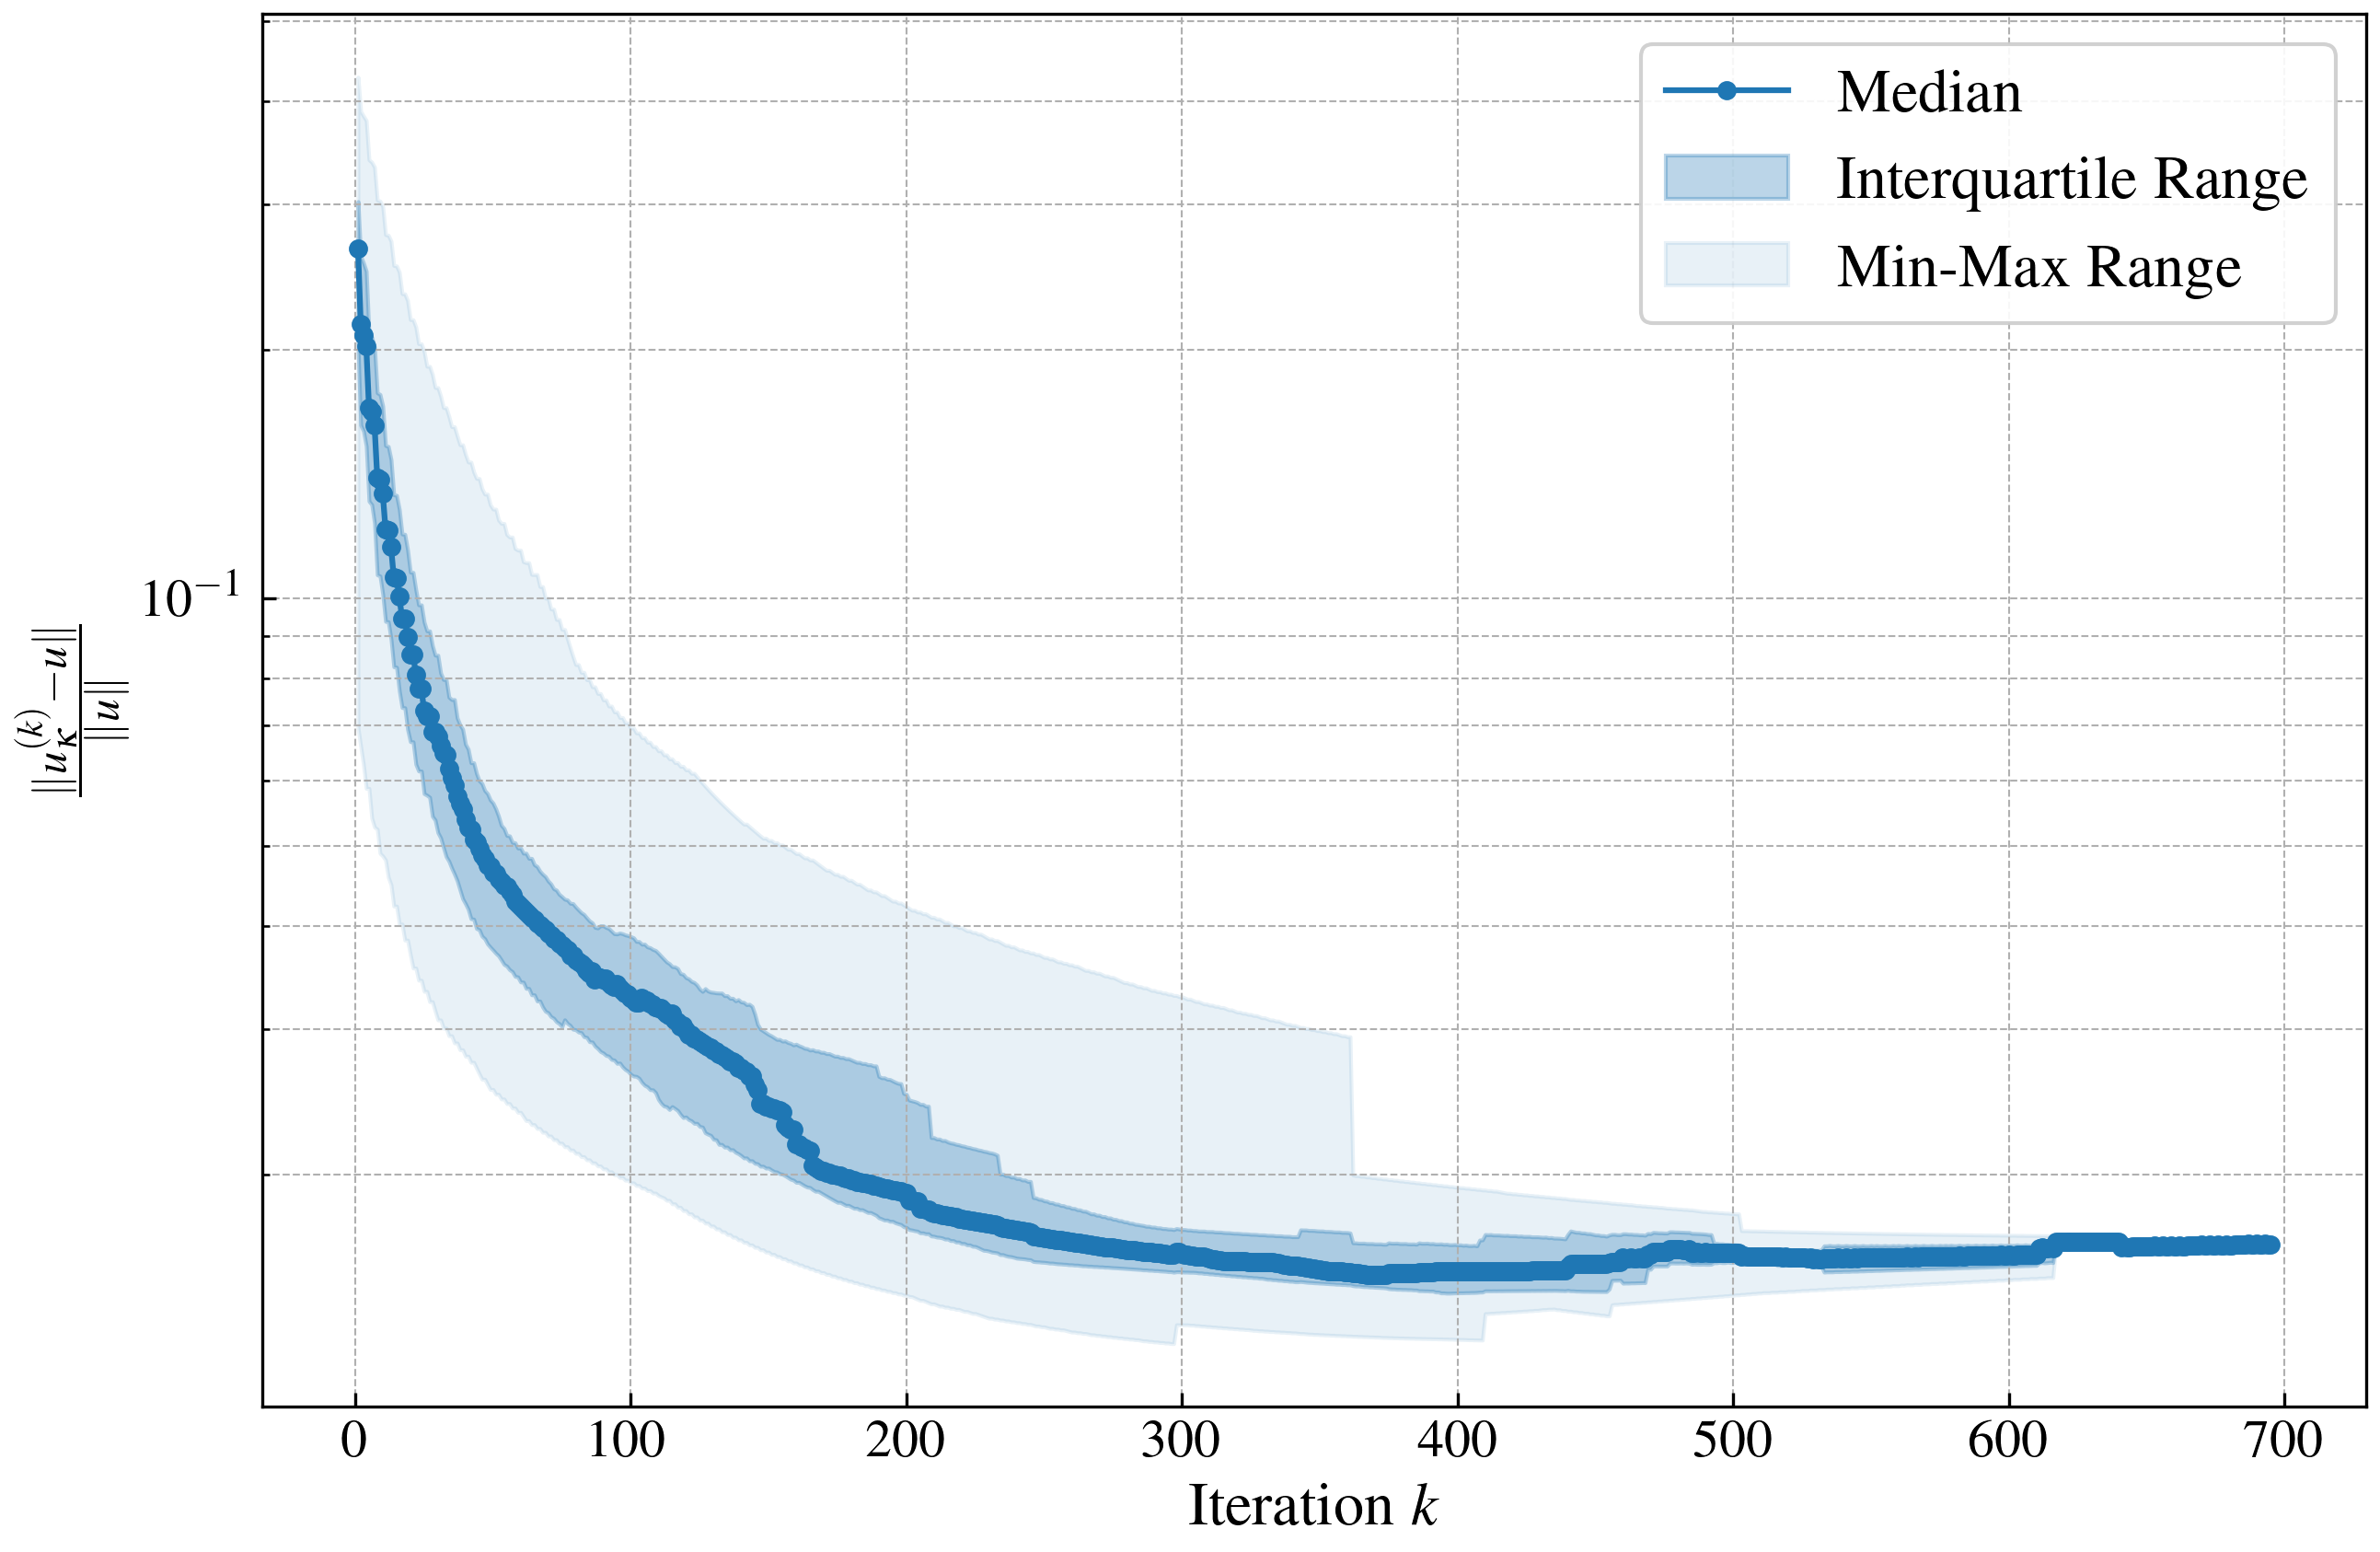

Saving figure to ../figures/denoiser-1e-5/solution_error_measured.pdf


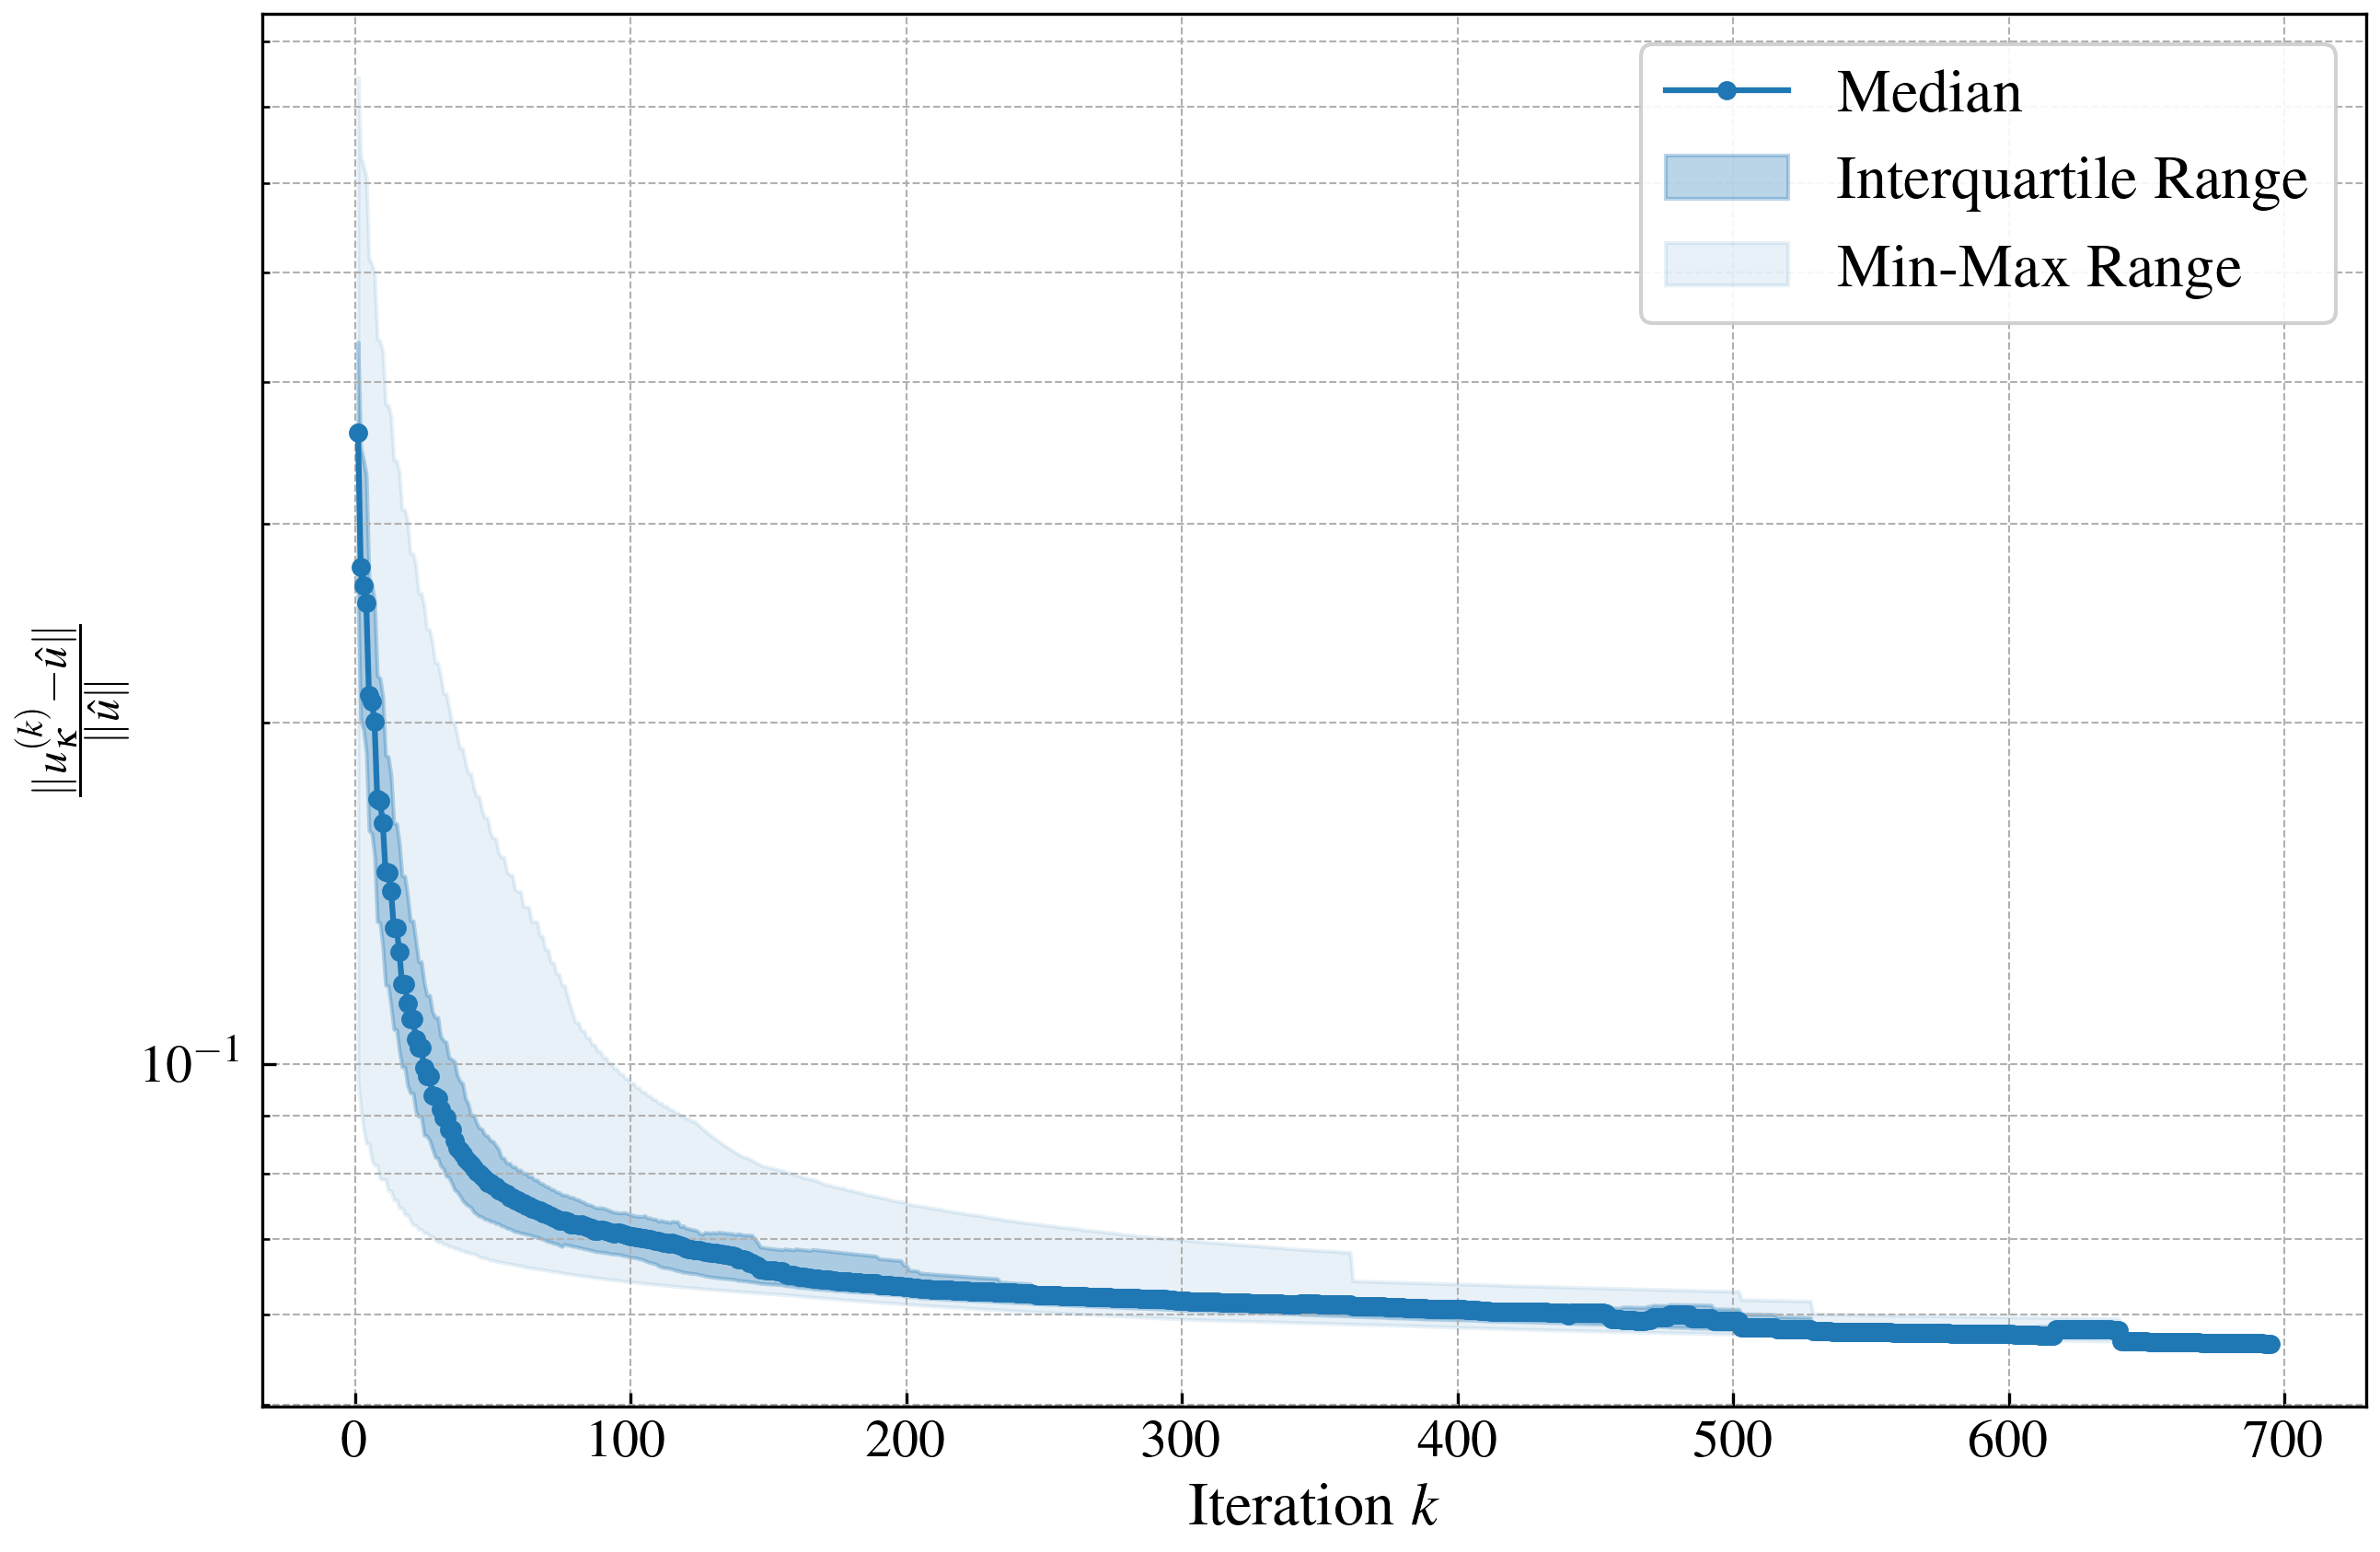

Saving figure to ../figures/denoiser-1e-5/kappa_error.pdf


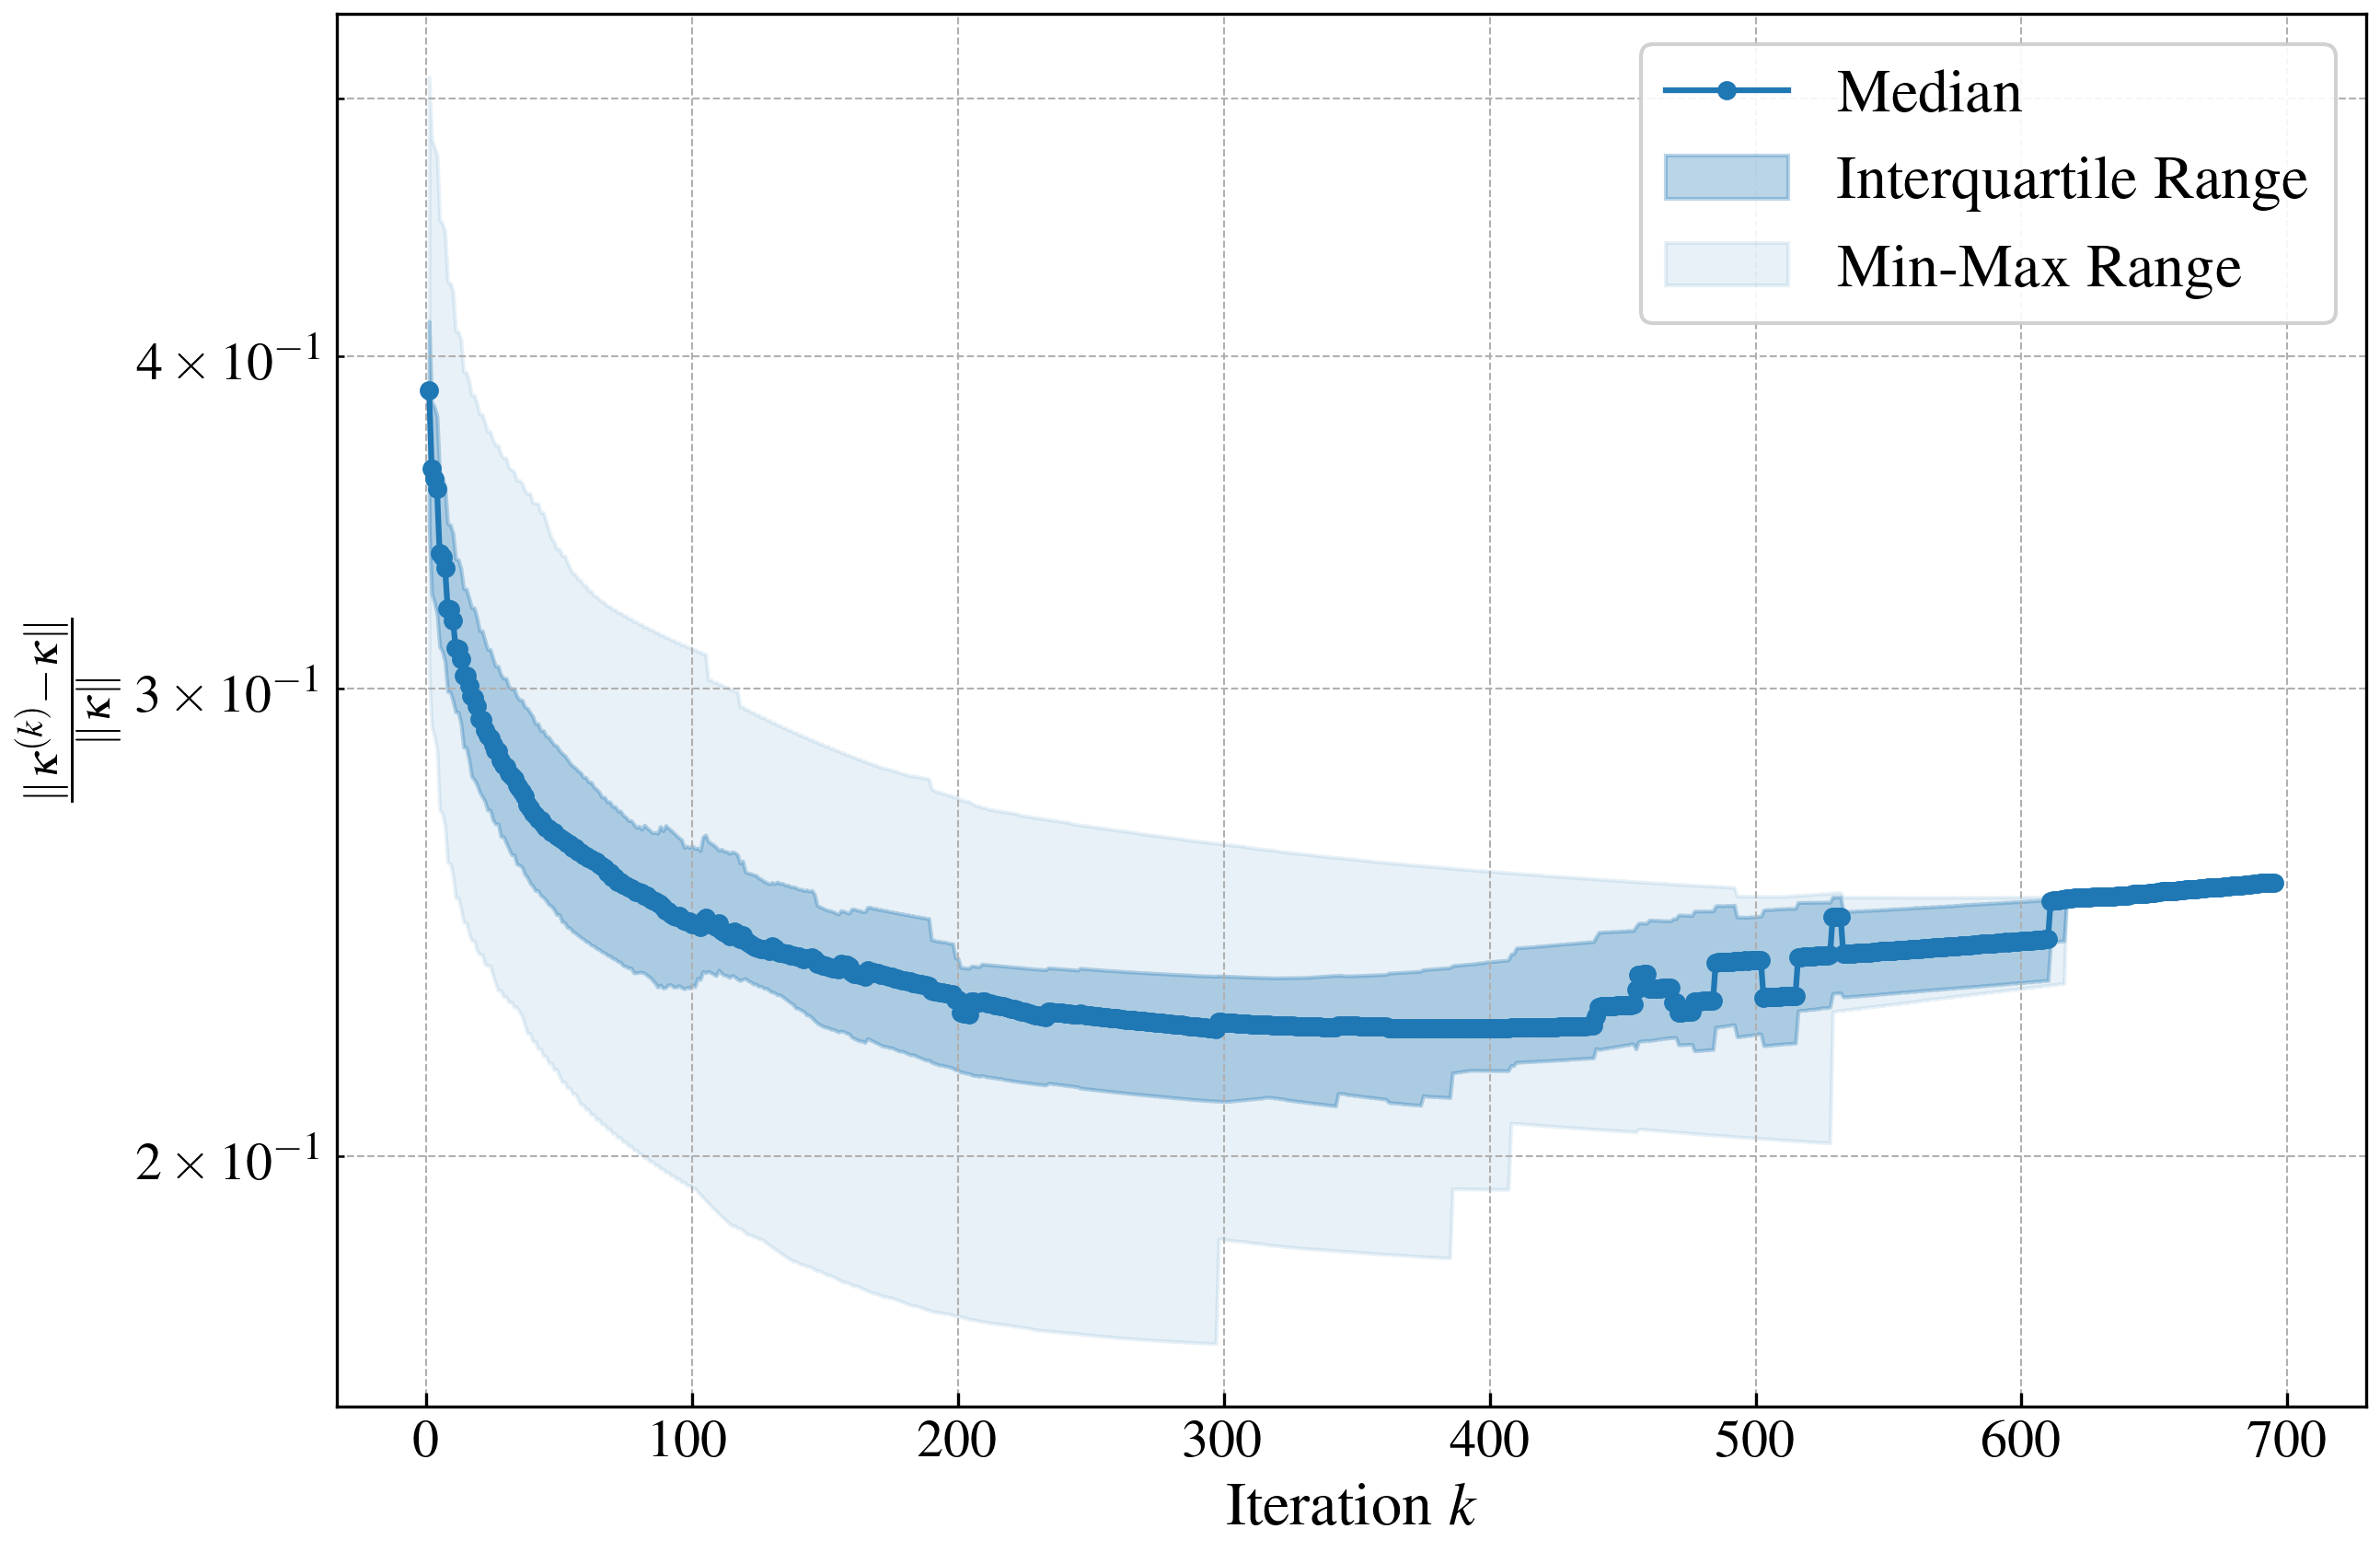

Saving figure to ../figures/denoiser-1e-5/objective_function.pdf


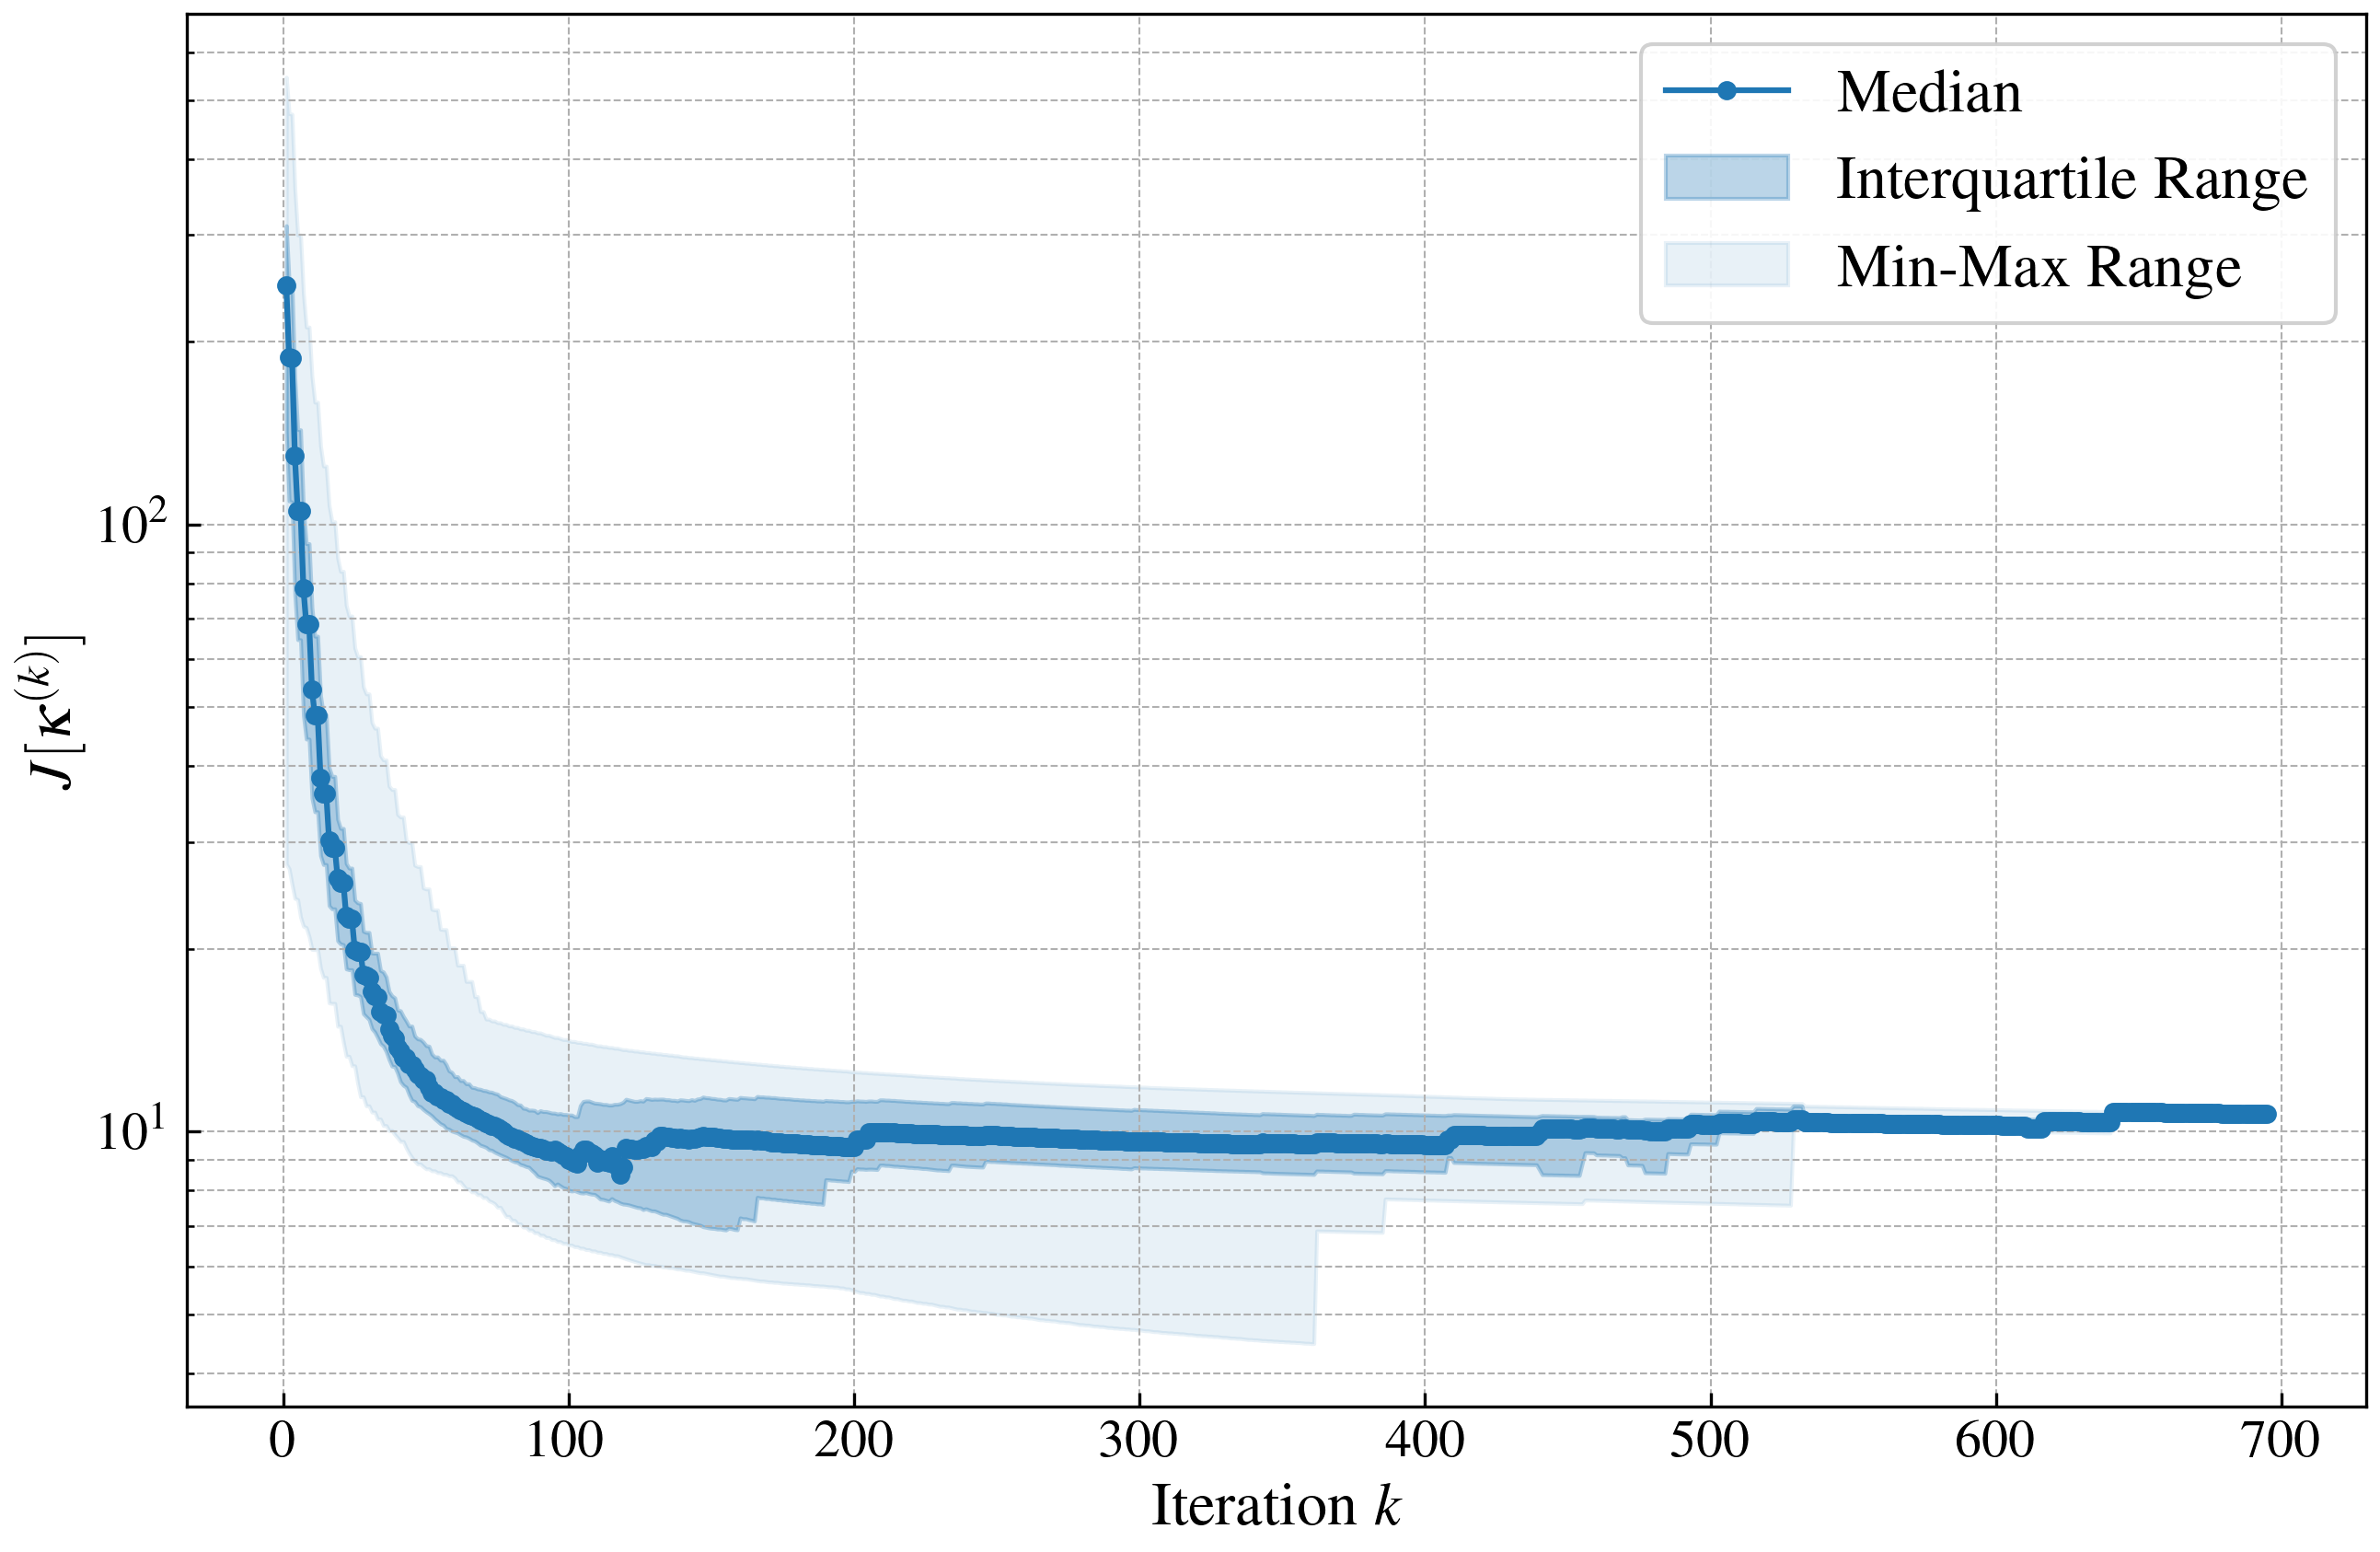

Saving figure to ../figures/denoiser-1e-5/regularization.pdf


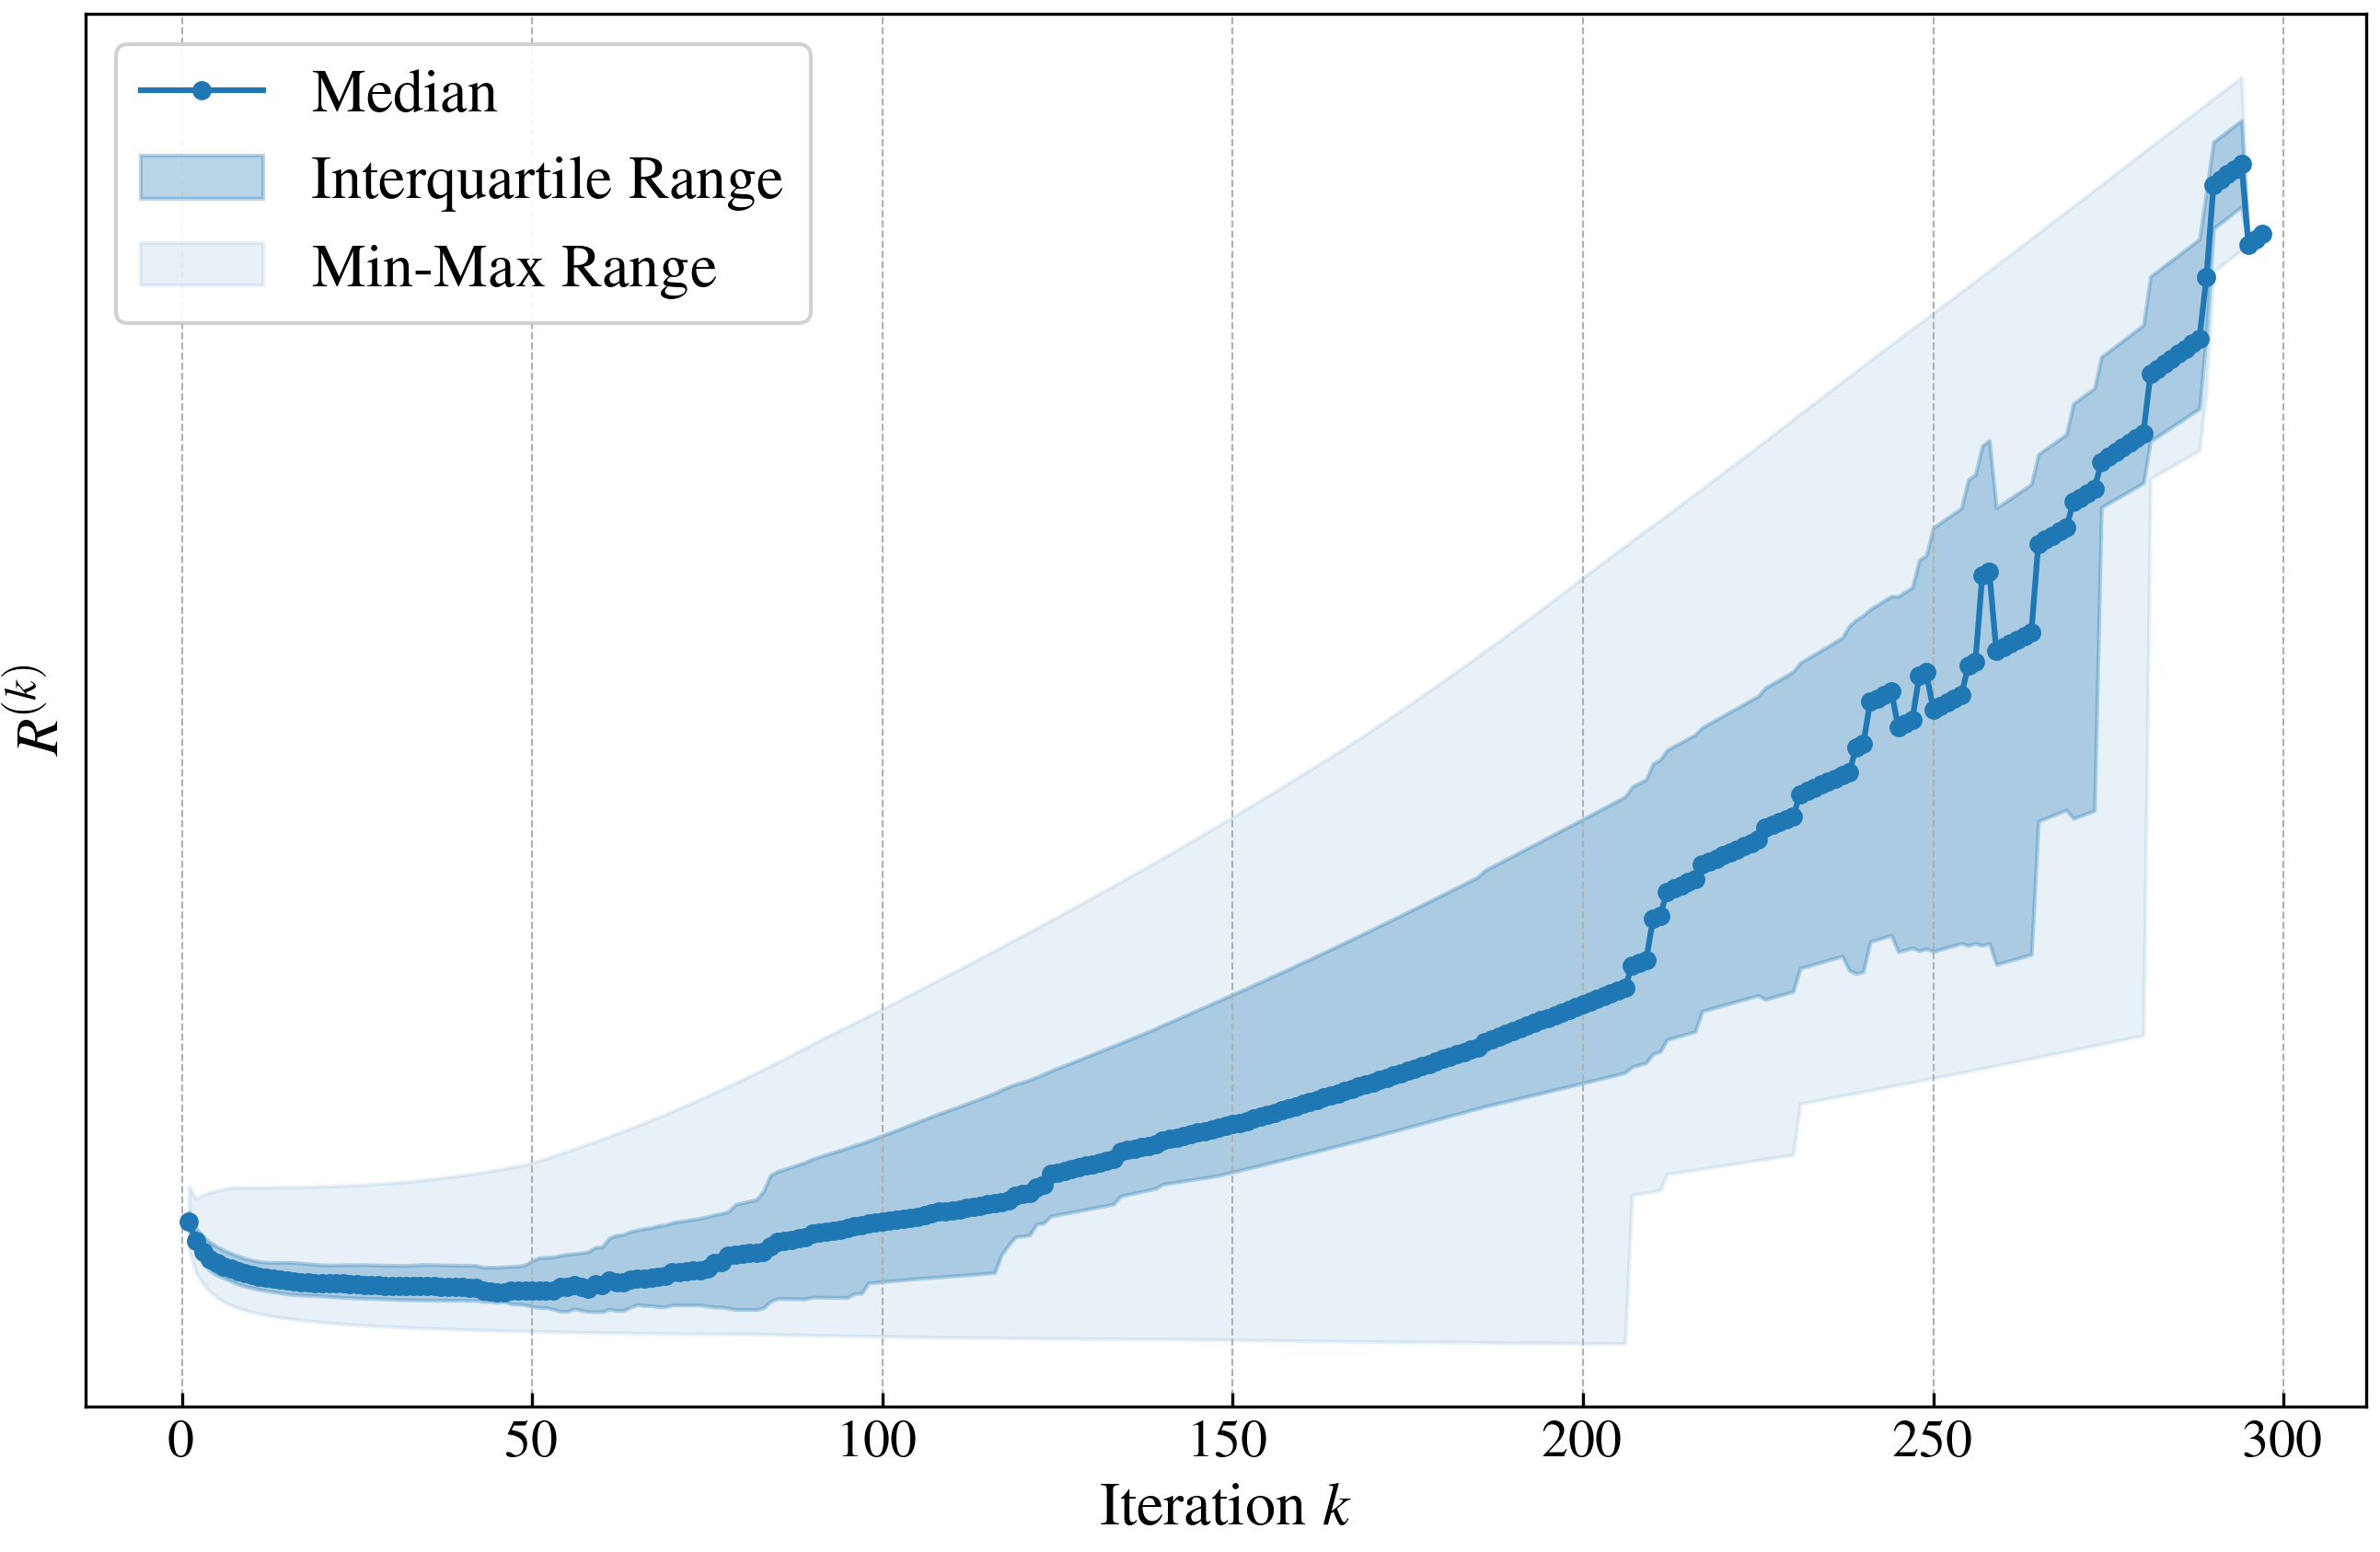

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl

# Set up matplotlib for publication quality
mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Times', 'Computer Modern Roman'],
    'font.size': 16,
    'axes.labelsize': 16,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 16,
    'figure.titlesize': 18,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'text.usetex': True,  # Enable LaTeX rendering
    'text.latex.preamble': r'\usepackage{amsmath}',
})

# Continue with data extraction

# Now create separate figures for each metric 
plot_configs = [
    # Solution error plots
    {
        "metric": "ukappa_iterates_rel_errors", 
        # "title": "Solution Relative Error vs. True Solution",
        "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - u\|}{\|u\|}$",
        "filename": "../figures/denoiser-1e-5/solution_error_true.pdf",
        "figsize": (9, 6)
    },
    {
        "metric": "ukappa_iterates_rel_errors_meas", 
        # "title": "Solution Relative Error vs. Measured Solution",
        "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - \hat{u}\|}{\|\hat{u}\|}$",
        "filename": "../figures/denoiser-1e-5/solution_error_measured.pdf",
        "figsize": (9, 6)
    },
    # Parameter error plot
    {
        "metric": "kappa_iterates_rel_errors", 
        # "title": "Parameter Relative Error",
        "ylabel": r"$\frac{\|\kappa^{(k)} - \kappa\|}{\|\kappa\|}$",
        "filename": "../figures/denoiser-1e-5/kappa_error.pdf",
        "figsize": (9, 6)
    },
    # Objective function plot
    {
        "metric": "objectives", 
        # "title": "Objective Function Value",
        "ylabel": r"$J[\kappa^{(k)}]$",
        "filename": "../figures/denoiser-1e-5/objective_function.pdf", 
        "figsize": (9, 6)
    },
    # Regularization parameter plot
    {
        "metric": "reg_values", 
        # "title": "Regularization Value",
        "ylabel": r"$R^{(k)}$",
        "filename": "../figures/denoiser-1e-5/regularization.pdf",
        "figsize": (9, 6)
    }
]

# Generate individual plots
for config in plot_configs:
    metric = config["metric"]
    
    # Skip if this metric is not in our data
    if metric not in padded_iterative_arrays:
        print(f"Skipping {metric}: Not found in data.")
        continue
        
    data_array = padded_iterative_arrays[metric]
    if data_array.size == 0: 
        print(f"Skipping {metric}: Empty data array.")
        continue
    
    # Check for columns/iterations with valid data
    valid_iterations_mask = ~np.all(np.isnan(data_array), axis=0)
    current_iterations_axis = iterations_axis[valid_iterations_mask]
    
    if len(current_iterations_axis) == 0:
        print(f"Skipping {metric}: No valid data points after padding.")
        continue
        
    # Calculate statistics
    median_vals = np.nanmedian(data_array[:, valid_iterations_mask], axis=0)
    q1_vals = np.nanpercentile(data_array[:, valid_iterations_mask], 25, axis=0)
    q3_vals = np.nanpercentile(data_array[:, valid_iterations_mask], 75, axis=0)
    min_vals = np.nanmin(data_array[:, valid_iterations_mask], axis=0)
    max_vals = np.nanmax(data_array[:, valid_iterations_mask], axis=0)
    
    # Create figure
    fig, ax = plt.figure(figsize=config["figsize"]), plt.gca()
    
    # Plot median with quartiles
    ax.plot(current_iterations_axis, median_vals, 'o-', color='#1f77b4', 
            linewidth=1.5, markersize=4, label='Median')
    ax.fill_between(current_iterations_axis, q1_vals, q3_vals, 
                    color='#1f77b4', alpha=0.3, label='Interquartile Range')
    
    # Add min-max range for broader perspective (optional)
    ax.fill_between(current_iterations_axis, min_vals, max_vals, 
                    color='#1f77b4', alpha=0.1, label='Min-Max Range')
    
    # Set labels with proper math notation
    ax.set_xlabel('Iteration $k$')
    ax.set_ylabel(config["ylabel"])
    ax.set_yticks([])
    # ax.set_title(config["title"])
    
    # Use log scale for error metrics and objectives
    if 'error' in metric.lower() or 'objective' in metric.lower():
        if np.nanmin(median_vals) > 0:
            ax.set_yscale('log')
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        else:
            print(f"Warning: Non-positive values in {metric}. Using linear scale.")
            ax.grid(True, linestyle='--', linewidth=0.5)
    else:
        ax.grid(True, linestyle='--', linewidth=0.5)
    
    # Add legend
    ax.legend(loc='best', frameon=True, framealpha=0.9)
    
    # # Add annotations
    # n_valid_runs = np.sum(~np.isnan(data_array[:, 0]))
    # plt.figtext(0.01, 0.01, f'Based on {n_valid_runs} valid runs', 
    #             fontsize=8, ha='left')
    
    # Make ticks inward
    ax.tick_params(direction='in', which='both')
    
    plt.tight_layout()
    
    # Save figure (optional - comment out if not needed)
    savepath = Path(config["filename"])
    if not savepath.exists():
        os.makedirs(savepath.parent, exist_ok=True)
    print(f"Saving figure to {savepath}")
    plt.savefig(savepath)
    
    plt.show()

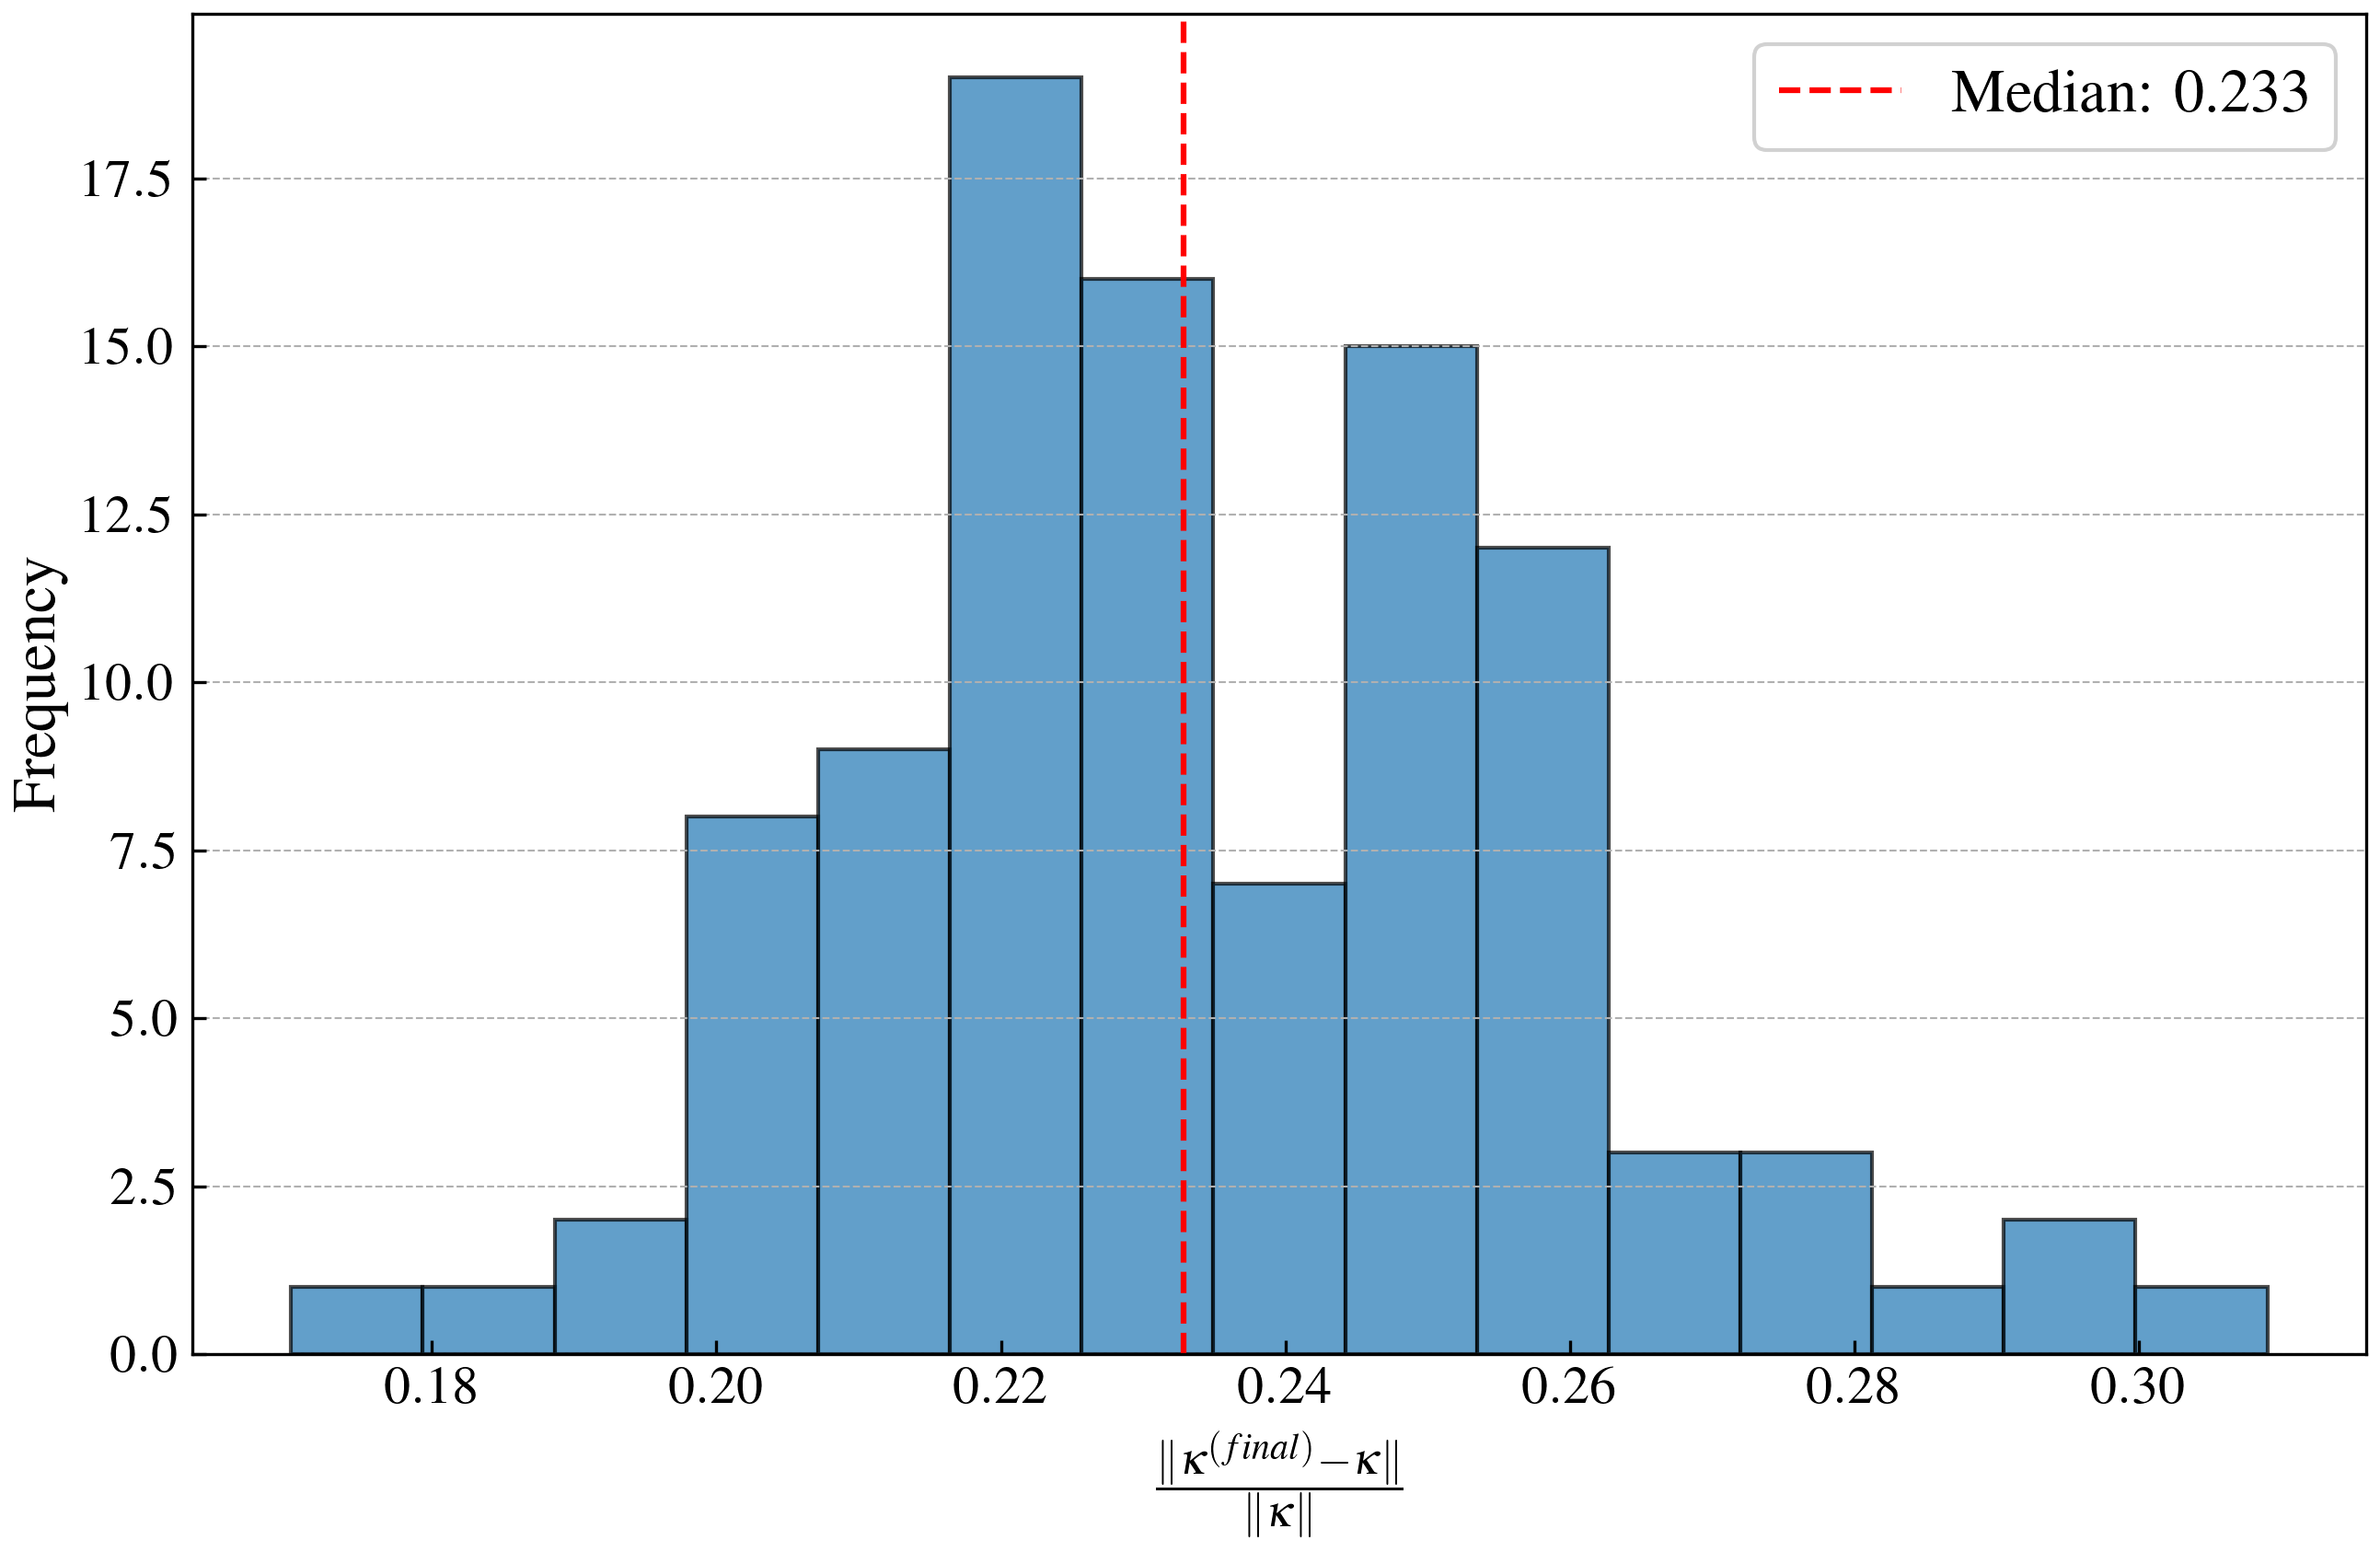

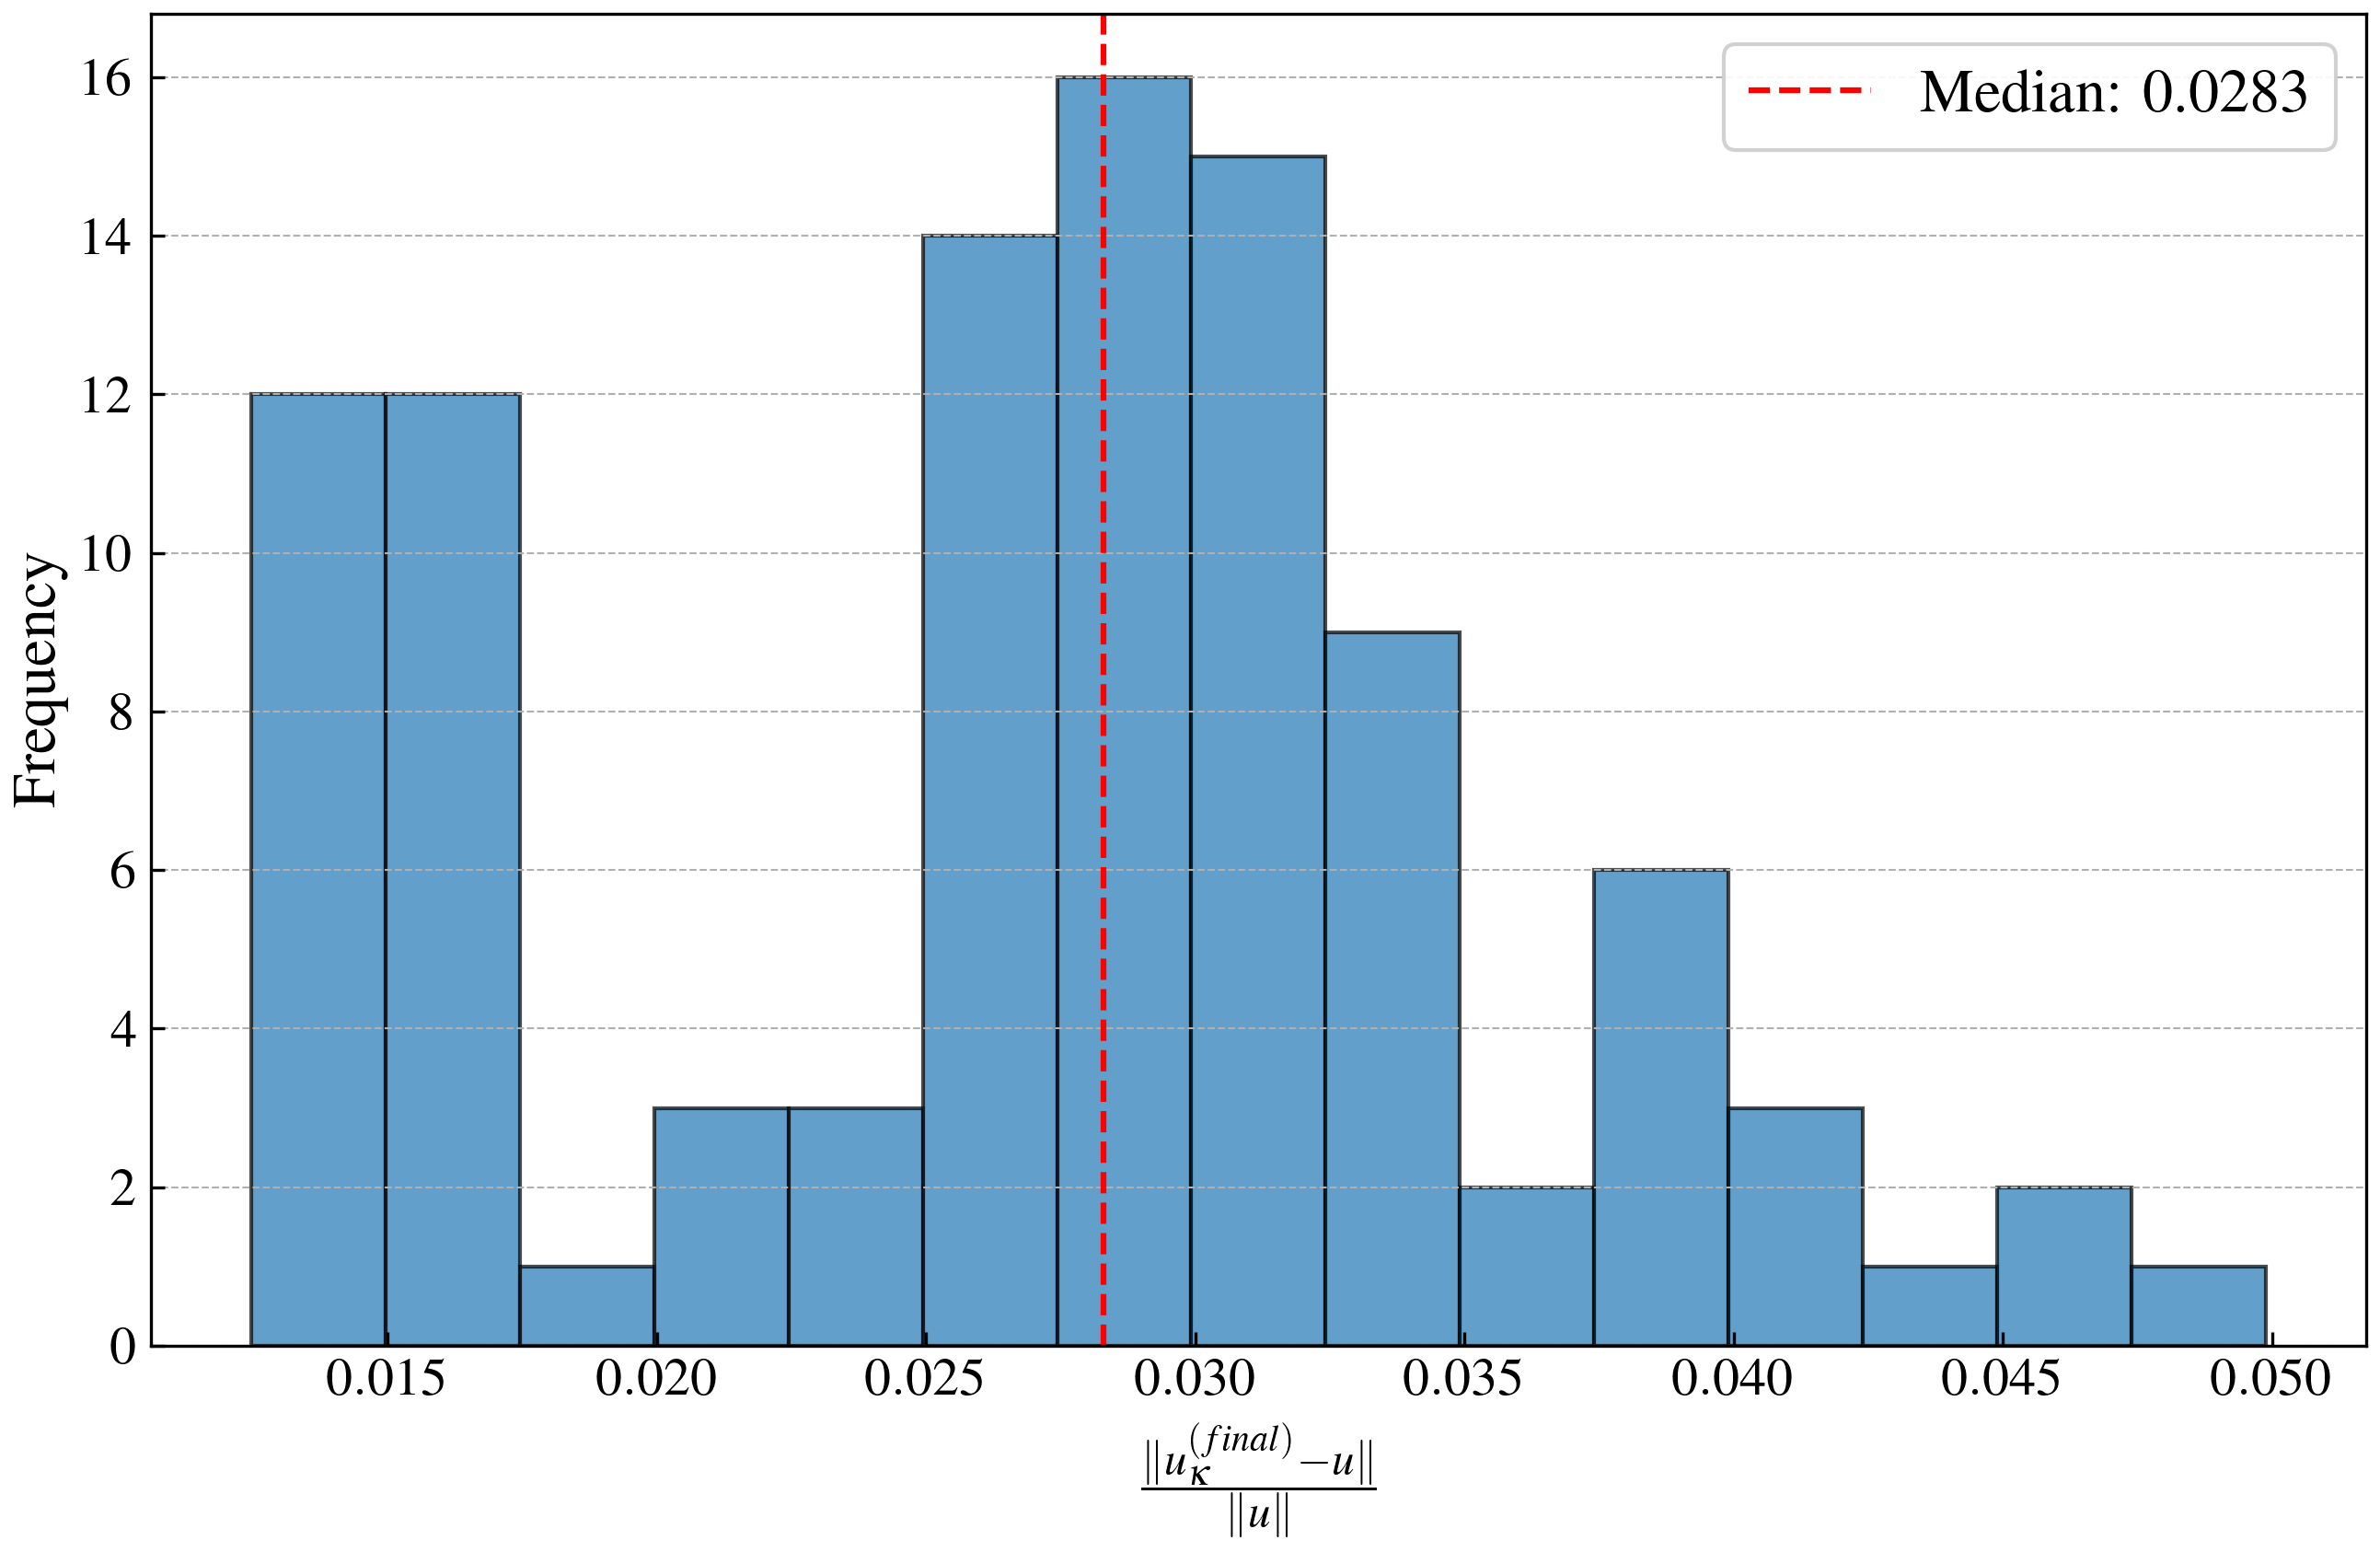

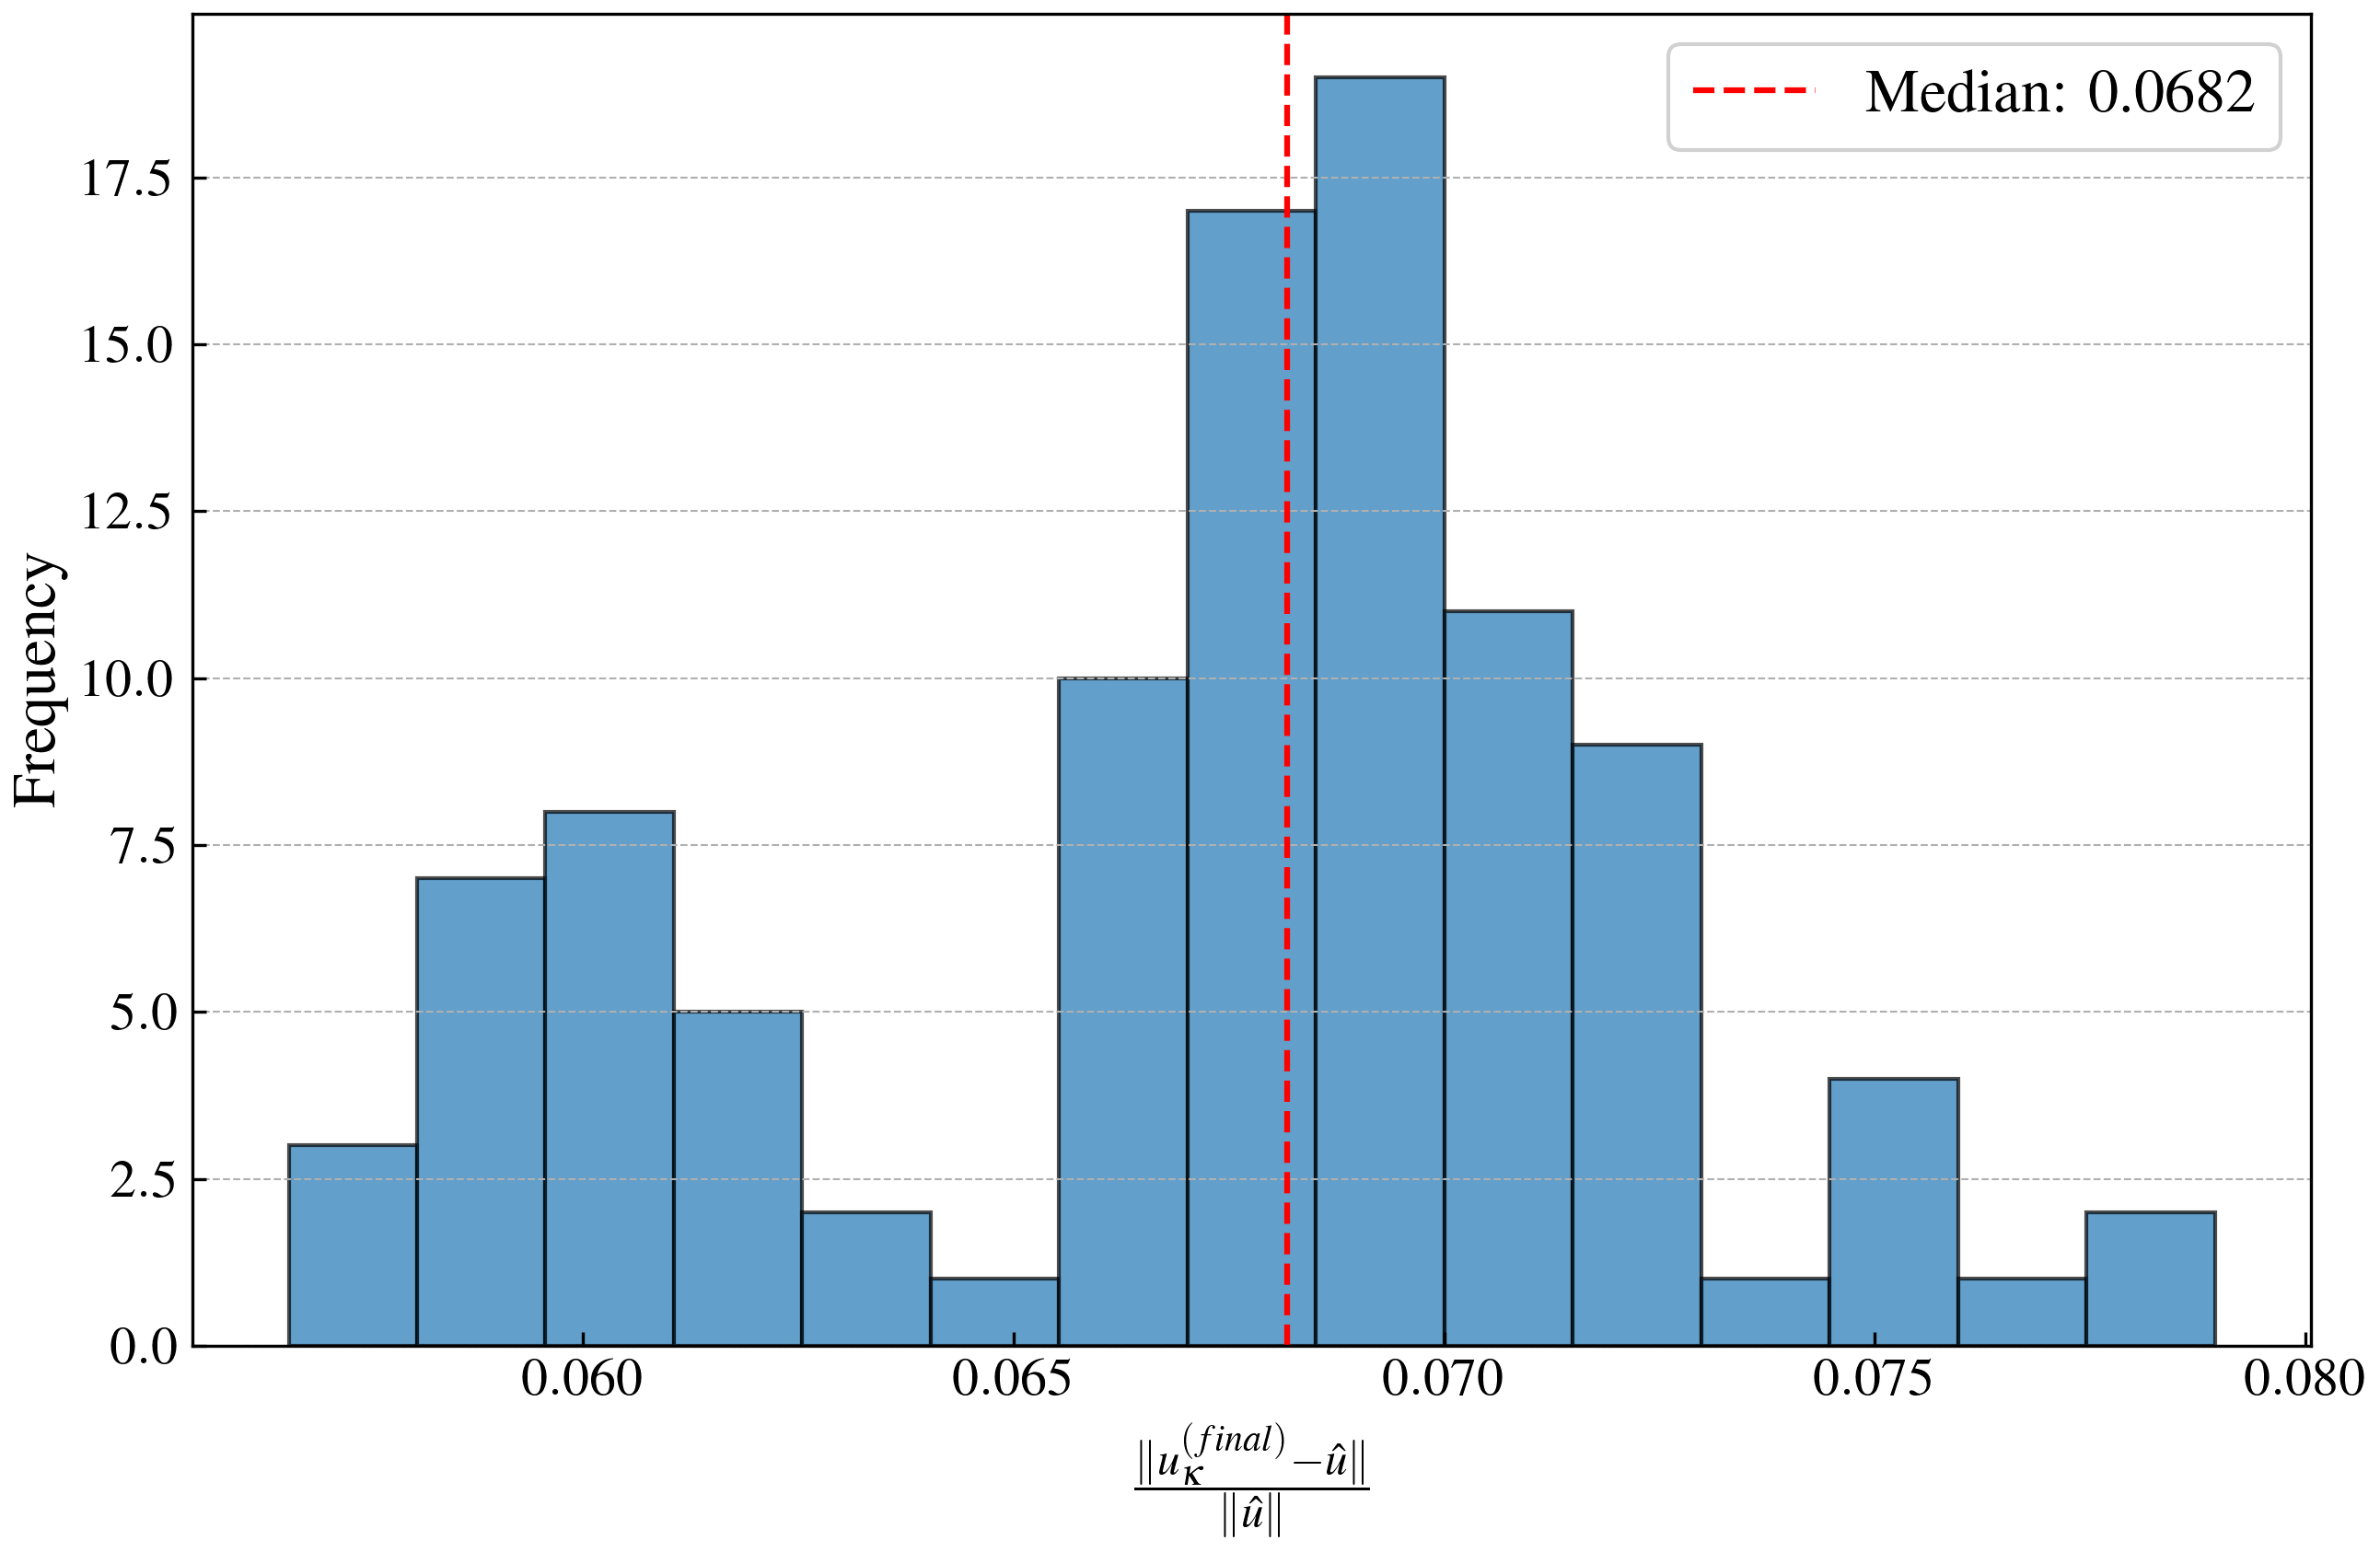

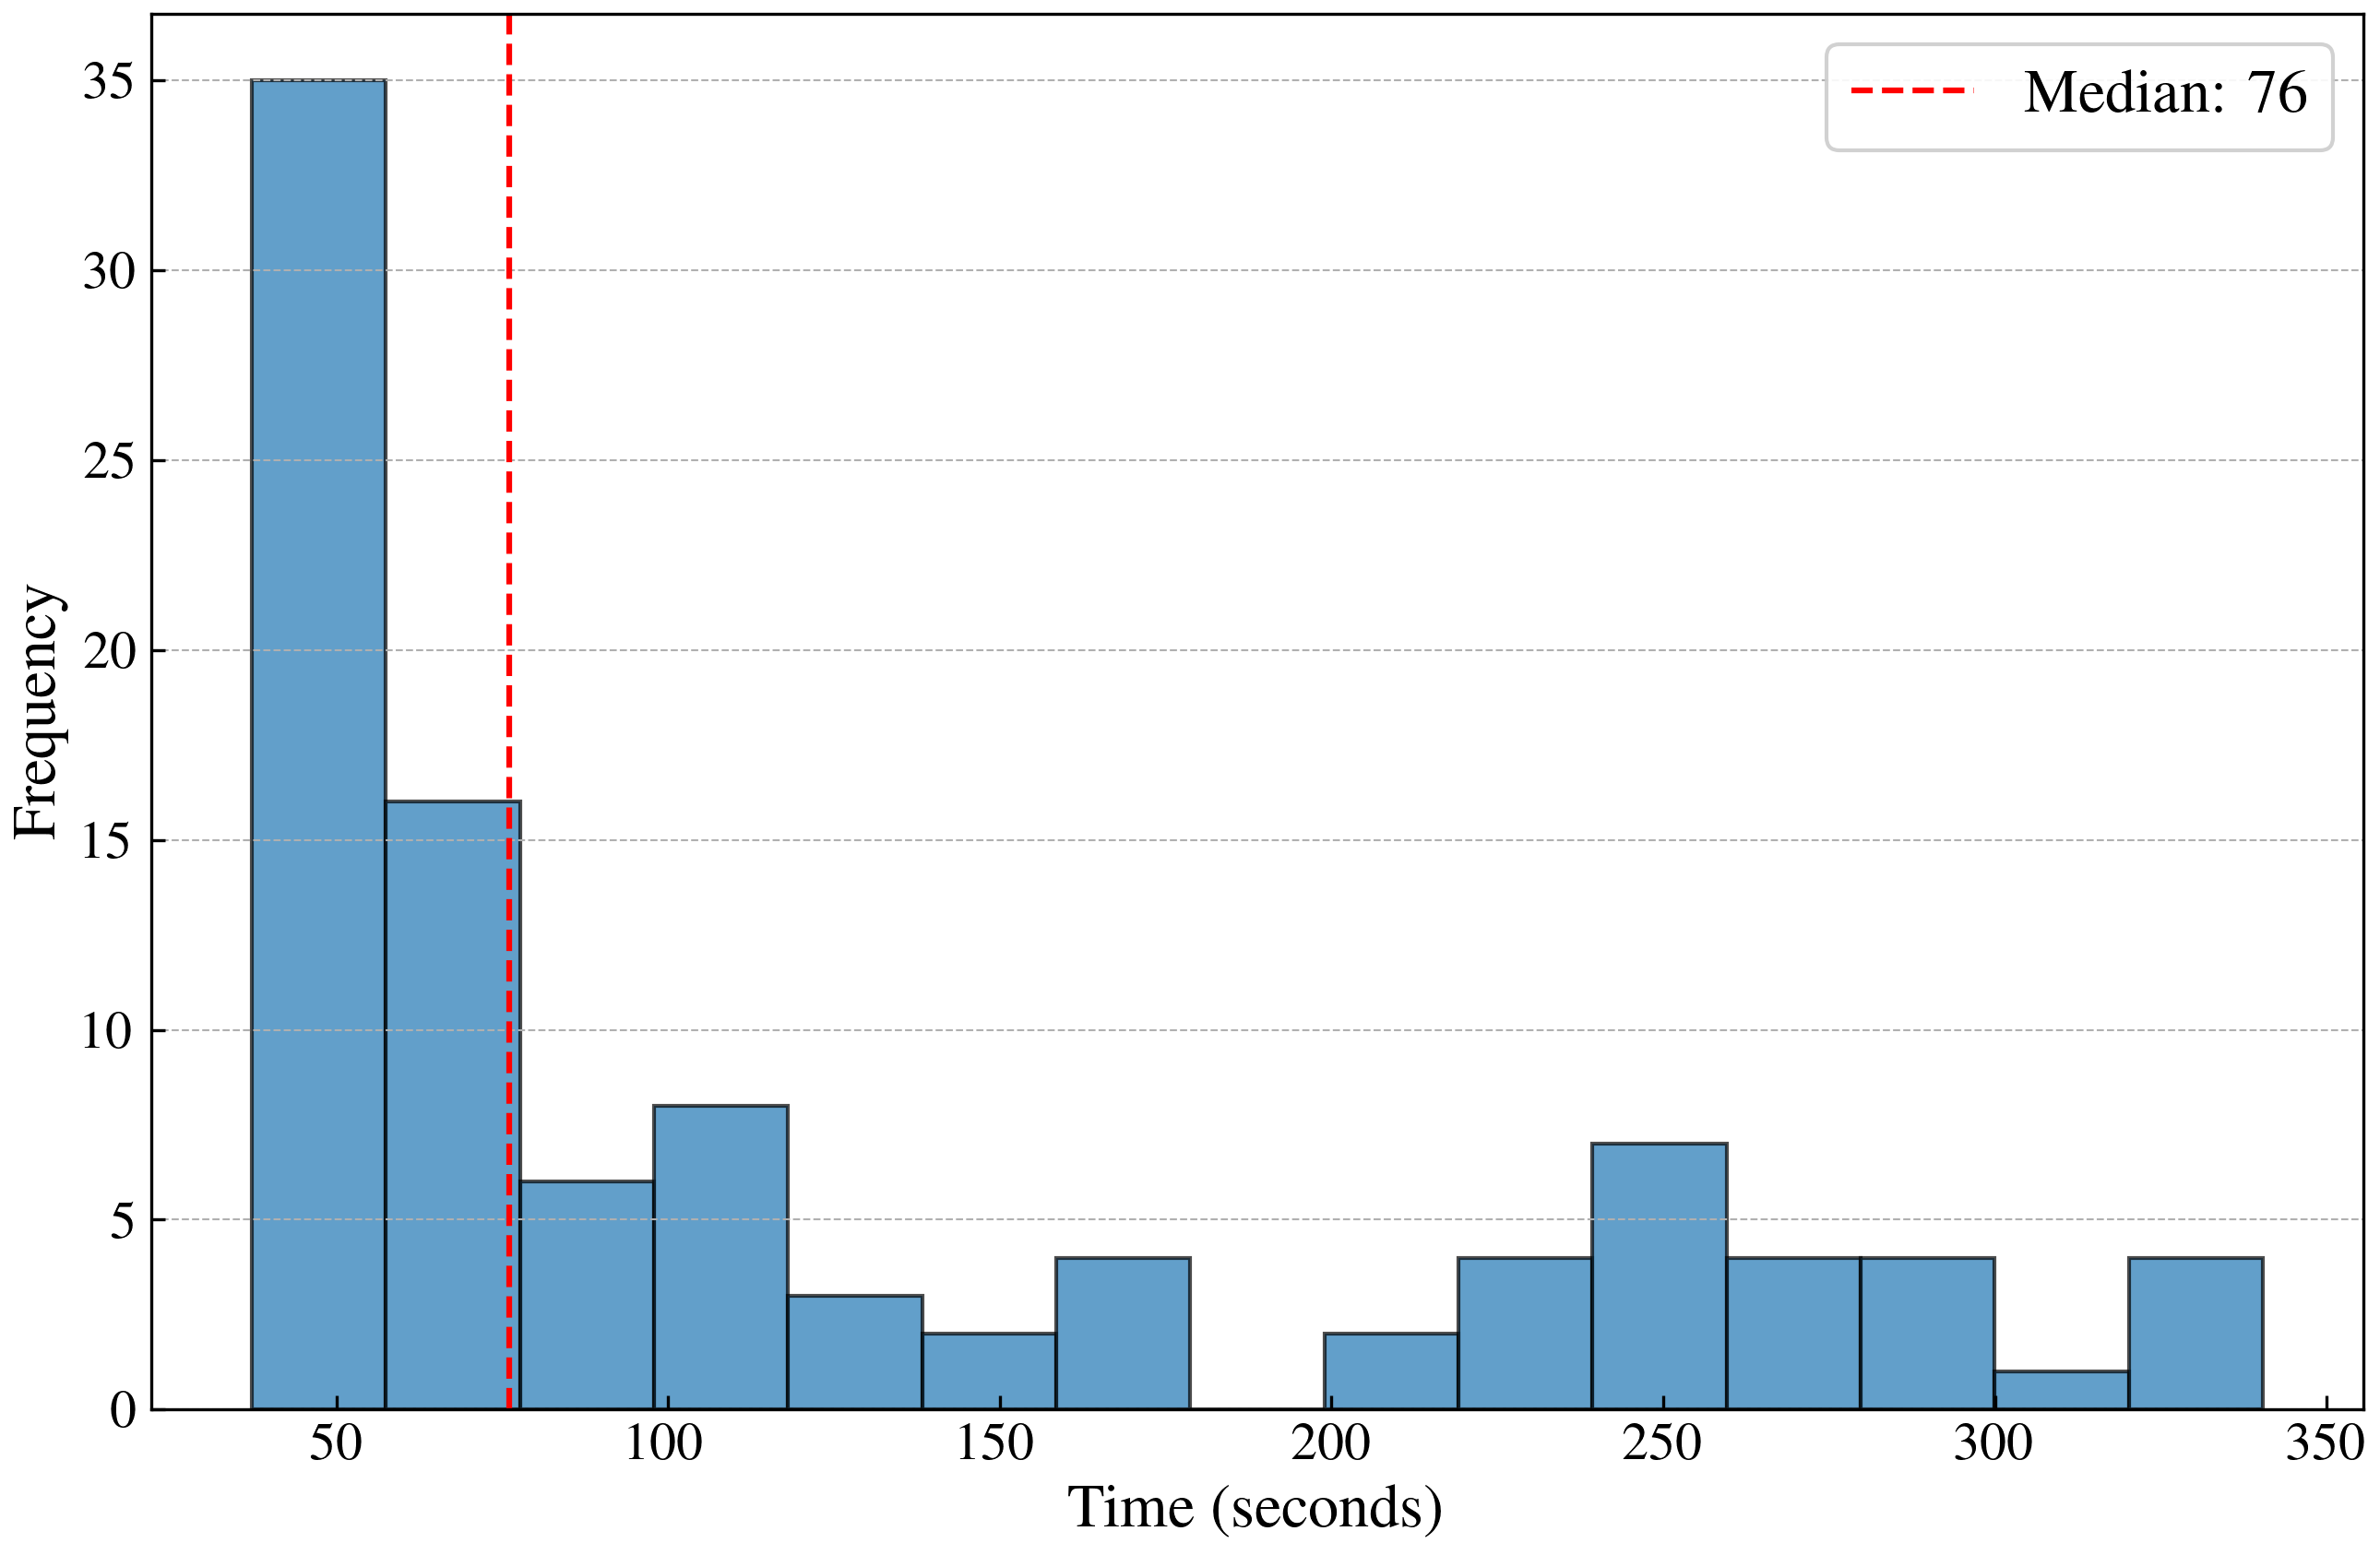

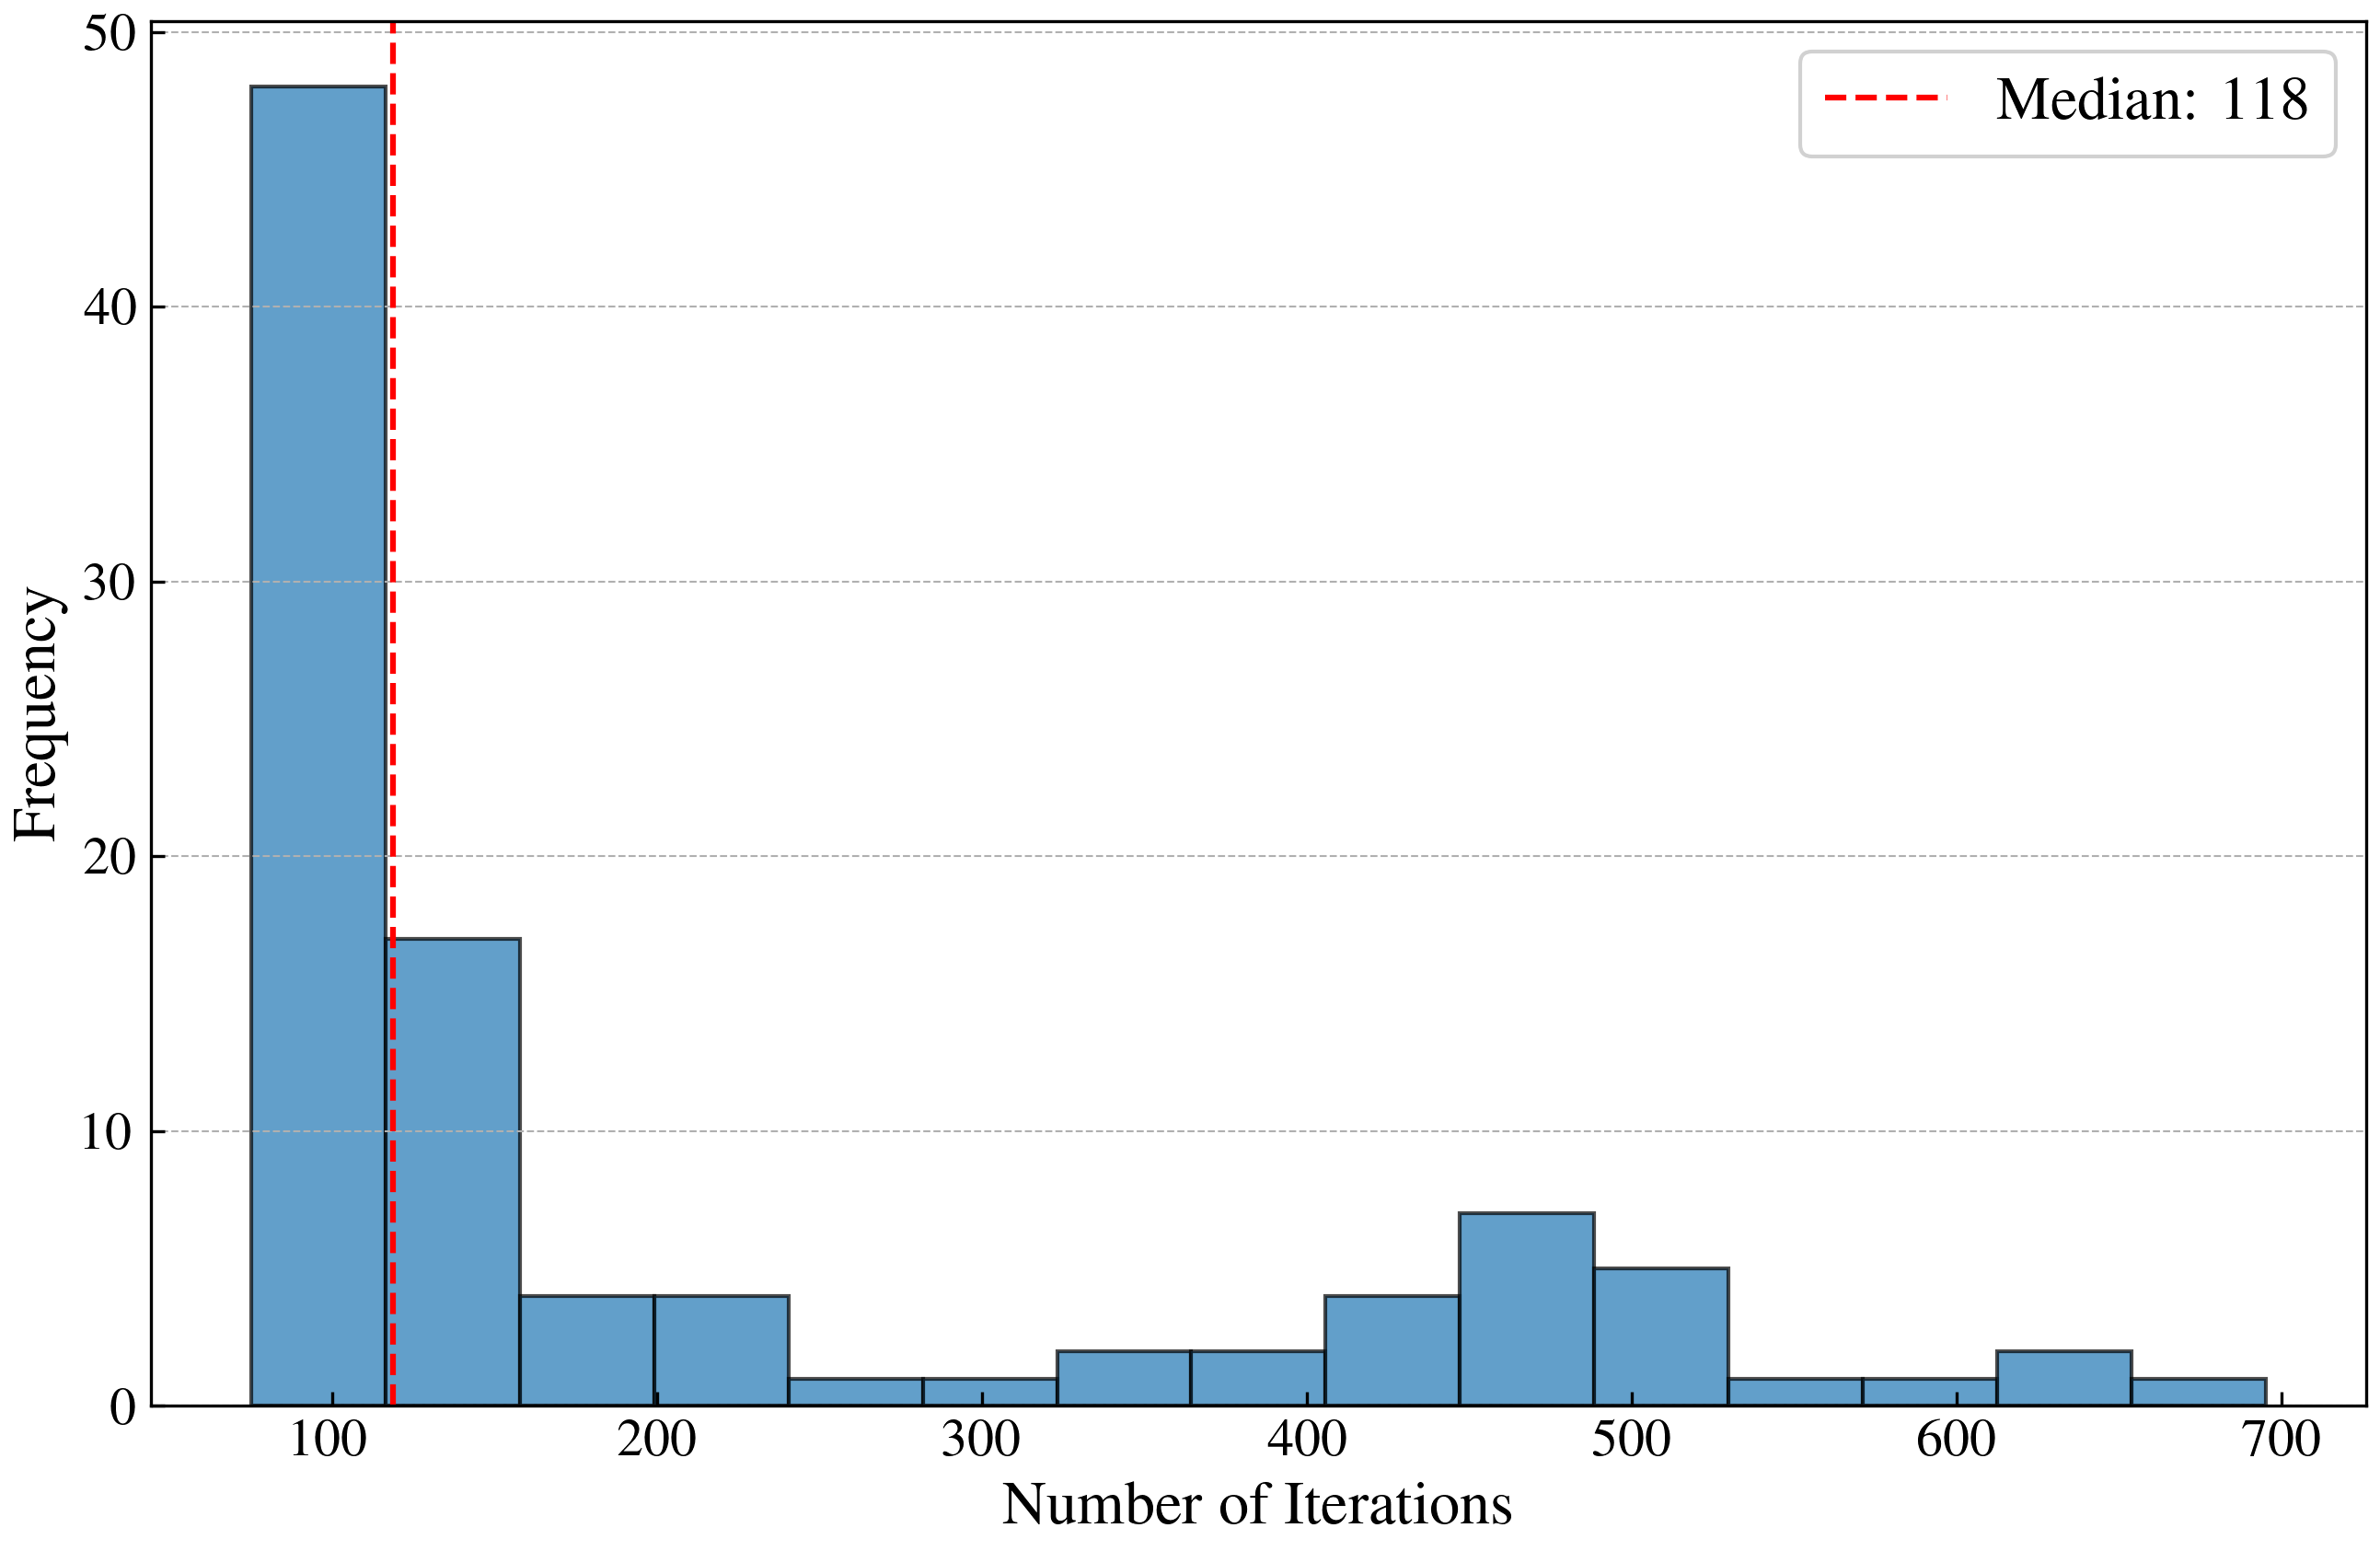

In [37]:
# --- Additional plots for final metric distributions ---
final_metric_configs = [
    {
        "metric": "kappa_final_rel_error",
        # "title": "Distribution of Final Parameter Error",
        "xlabel": r"$\frac{\|\kappa^{(final)} - \kappa\|}{\|\kappa\|}$",
        "filename": "final_kappa_error_dist.pdf",
        "figsize": (9, 6)
    },
    {
        "metric": "ukappa_recovered_rel_error",
        # "title": "Distribution of Final Solution Error (vs. True)",
        "xlabel": r"$\frac{\|u_{\kappa}^{(final)} - u\|}{\|u\|}$",
        "filename": "final_solution_error_true_dist.pdf",
        "figsize": (9, 6)
    },
    {
        "metric": "ukappa_recovered_rel_error_meas",
        # "title": "Distribution of Final Solution Error (vs. Measured)",
        "xlabel": r"$\frac{\|u_{\kappa}^{(final)} - \hat{u}\|}{\|\hat{u}\|}$",
        "filename": "final_solution_error_measured_dist.pdf",
        "figsize": (9, 6)
    },
    {
        "metric": "total_optimization_time",
        # "title": "Distribution of Total Optimization Time",
        "xlabel": "Time (seconds)",
        "filename": "optimization_time_dist.pdf",
        "figsize": (9, 6)
    },
    {
        "metric": "iterations",
        # "title": "Distribution of Iteration Counts",
        "xlabel": "Number of Iterations",
        "filename": "iteration_count_dist.pdf",
        "figsize": (9, 6)
    }
]

# Generate individual distribution plots
for config in final_metric_configs:
    metric = config["metric"]
    
    # Filter out NaNs
    data_list = [val for val in extracted_final[metric] if pd.notna(val)]
    if not data_list:
        print(f"No valid data for final metric: {metric}")
        continue
    
    # Create publication-quality figure
    fig, ax = plt.figure(figsize=config["figsize"]), plt.gca()
    
    # Plot histogram
    hist_bins = min(15, len(set(data_list)))  # Adjust bins based on unique values
    n, bins, patches = ax.hist(data_list, bins=hist_bins, edgecolor='black', 
                              alpha=0.7, color='#1f77b4')
    
    # Set labels
    ax.set_xlabel(config["xlabel"])
    ax.set_ylabel("Frequency")
    # ax.set_title(config["title"])
    
    # Add median line
    median_val = np.median(data_list)
    ax.axvline(median_val, color='red', linestyle='dashed', linewidth=1.5, 
              label=f'Median: {median_val:.3g}')
    
    # Use log scale if appropriate
    min_val, max_val = np.min(data_list), np.max(data_list)
    if 'error' in metric.lower() and min_val > 0 and max_val / min_val > 100:
        ax.set_xscale('log')
    
    # Add legend and grid
    ax.legend(loc='best', frameon=True, framealpha=0.9)
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
    
    # Make ticks inward
    ax.tick_params(direction='in', which='both')
    
    # # Add annotations
    # plt.figtext(0.01, 0.01, f'Based on {len(data_list)} valid runs', 
    #             fontsize=8, ha='left')
    
    plt.tight_layout()
    
    # Save figure (optional - comment out if not needed)
    # plt.savefig(config["filename"])
    
    plt.show()

<>:200: SyntaxWarning: invalid escape sequence '\l'
<>:206: SyntaxWarning: invalid escape sequence '\l'
<>:211: SyntaxWarning: invalid escape sequence '\l'
<>:200: SyntaxWarning: invalid escape sequence '\l'
<>:206: SyntaxWarning: invalid escape sequence '\l'
<>:211: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3390073/554822836.py:200: SyntaxWarning: invalid escape sequence '\l'
  label=f"Median $\lambda = {reg}$")
/tmp/ipykernel_3390073/554822836.py:206: SyntaxWarning: invalid escape sequence '\l'
  label=f"IQR $\lambda = {reg}$")
/tmp/ipykernel_3390073/554822836.py:211: SyntaxWarning: invalid escape sequence '\l'
  label=f"Min-Max Range $\lambda = {reg}$")


Found 100 runs with valid iteration counts. Max iterations: 448
Found 100 runs with valid iteration counts. Max iterations: 695
Found 100 runs with valid iteration counts. Max iterations: 683


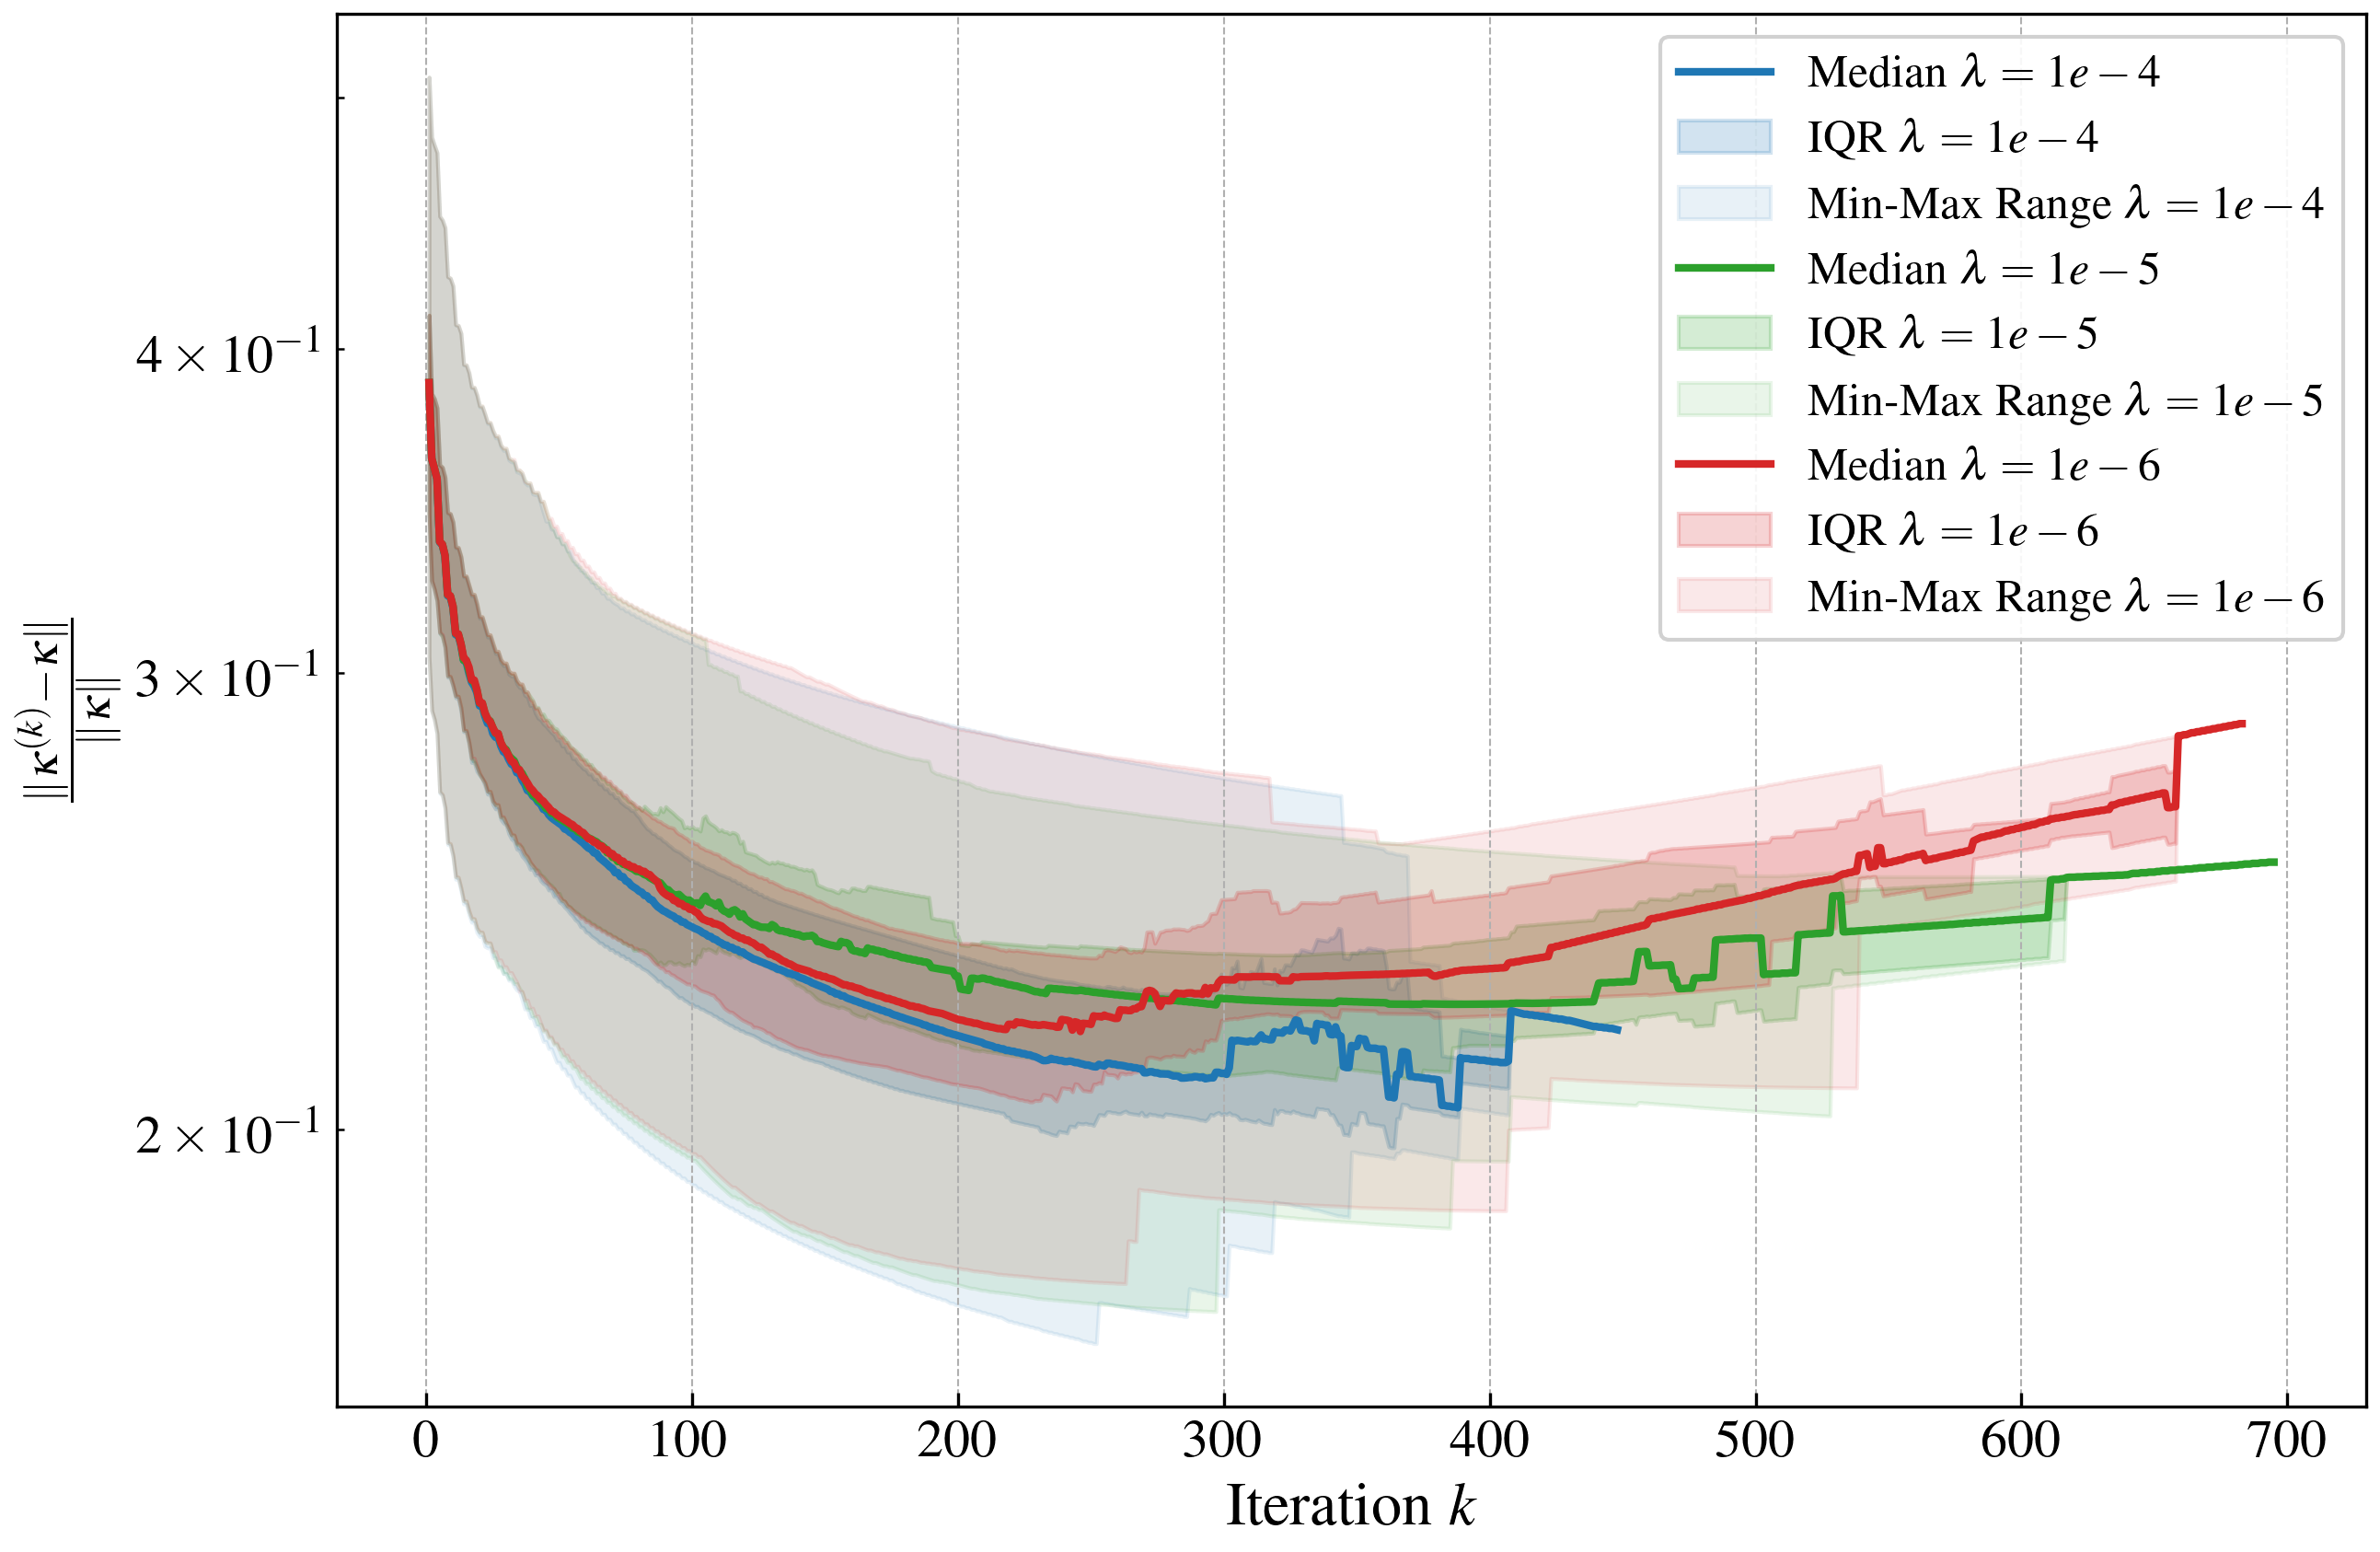

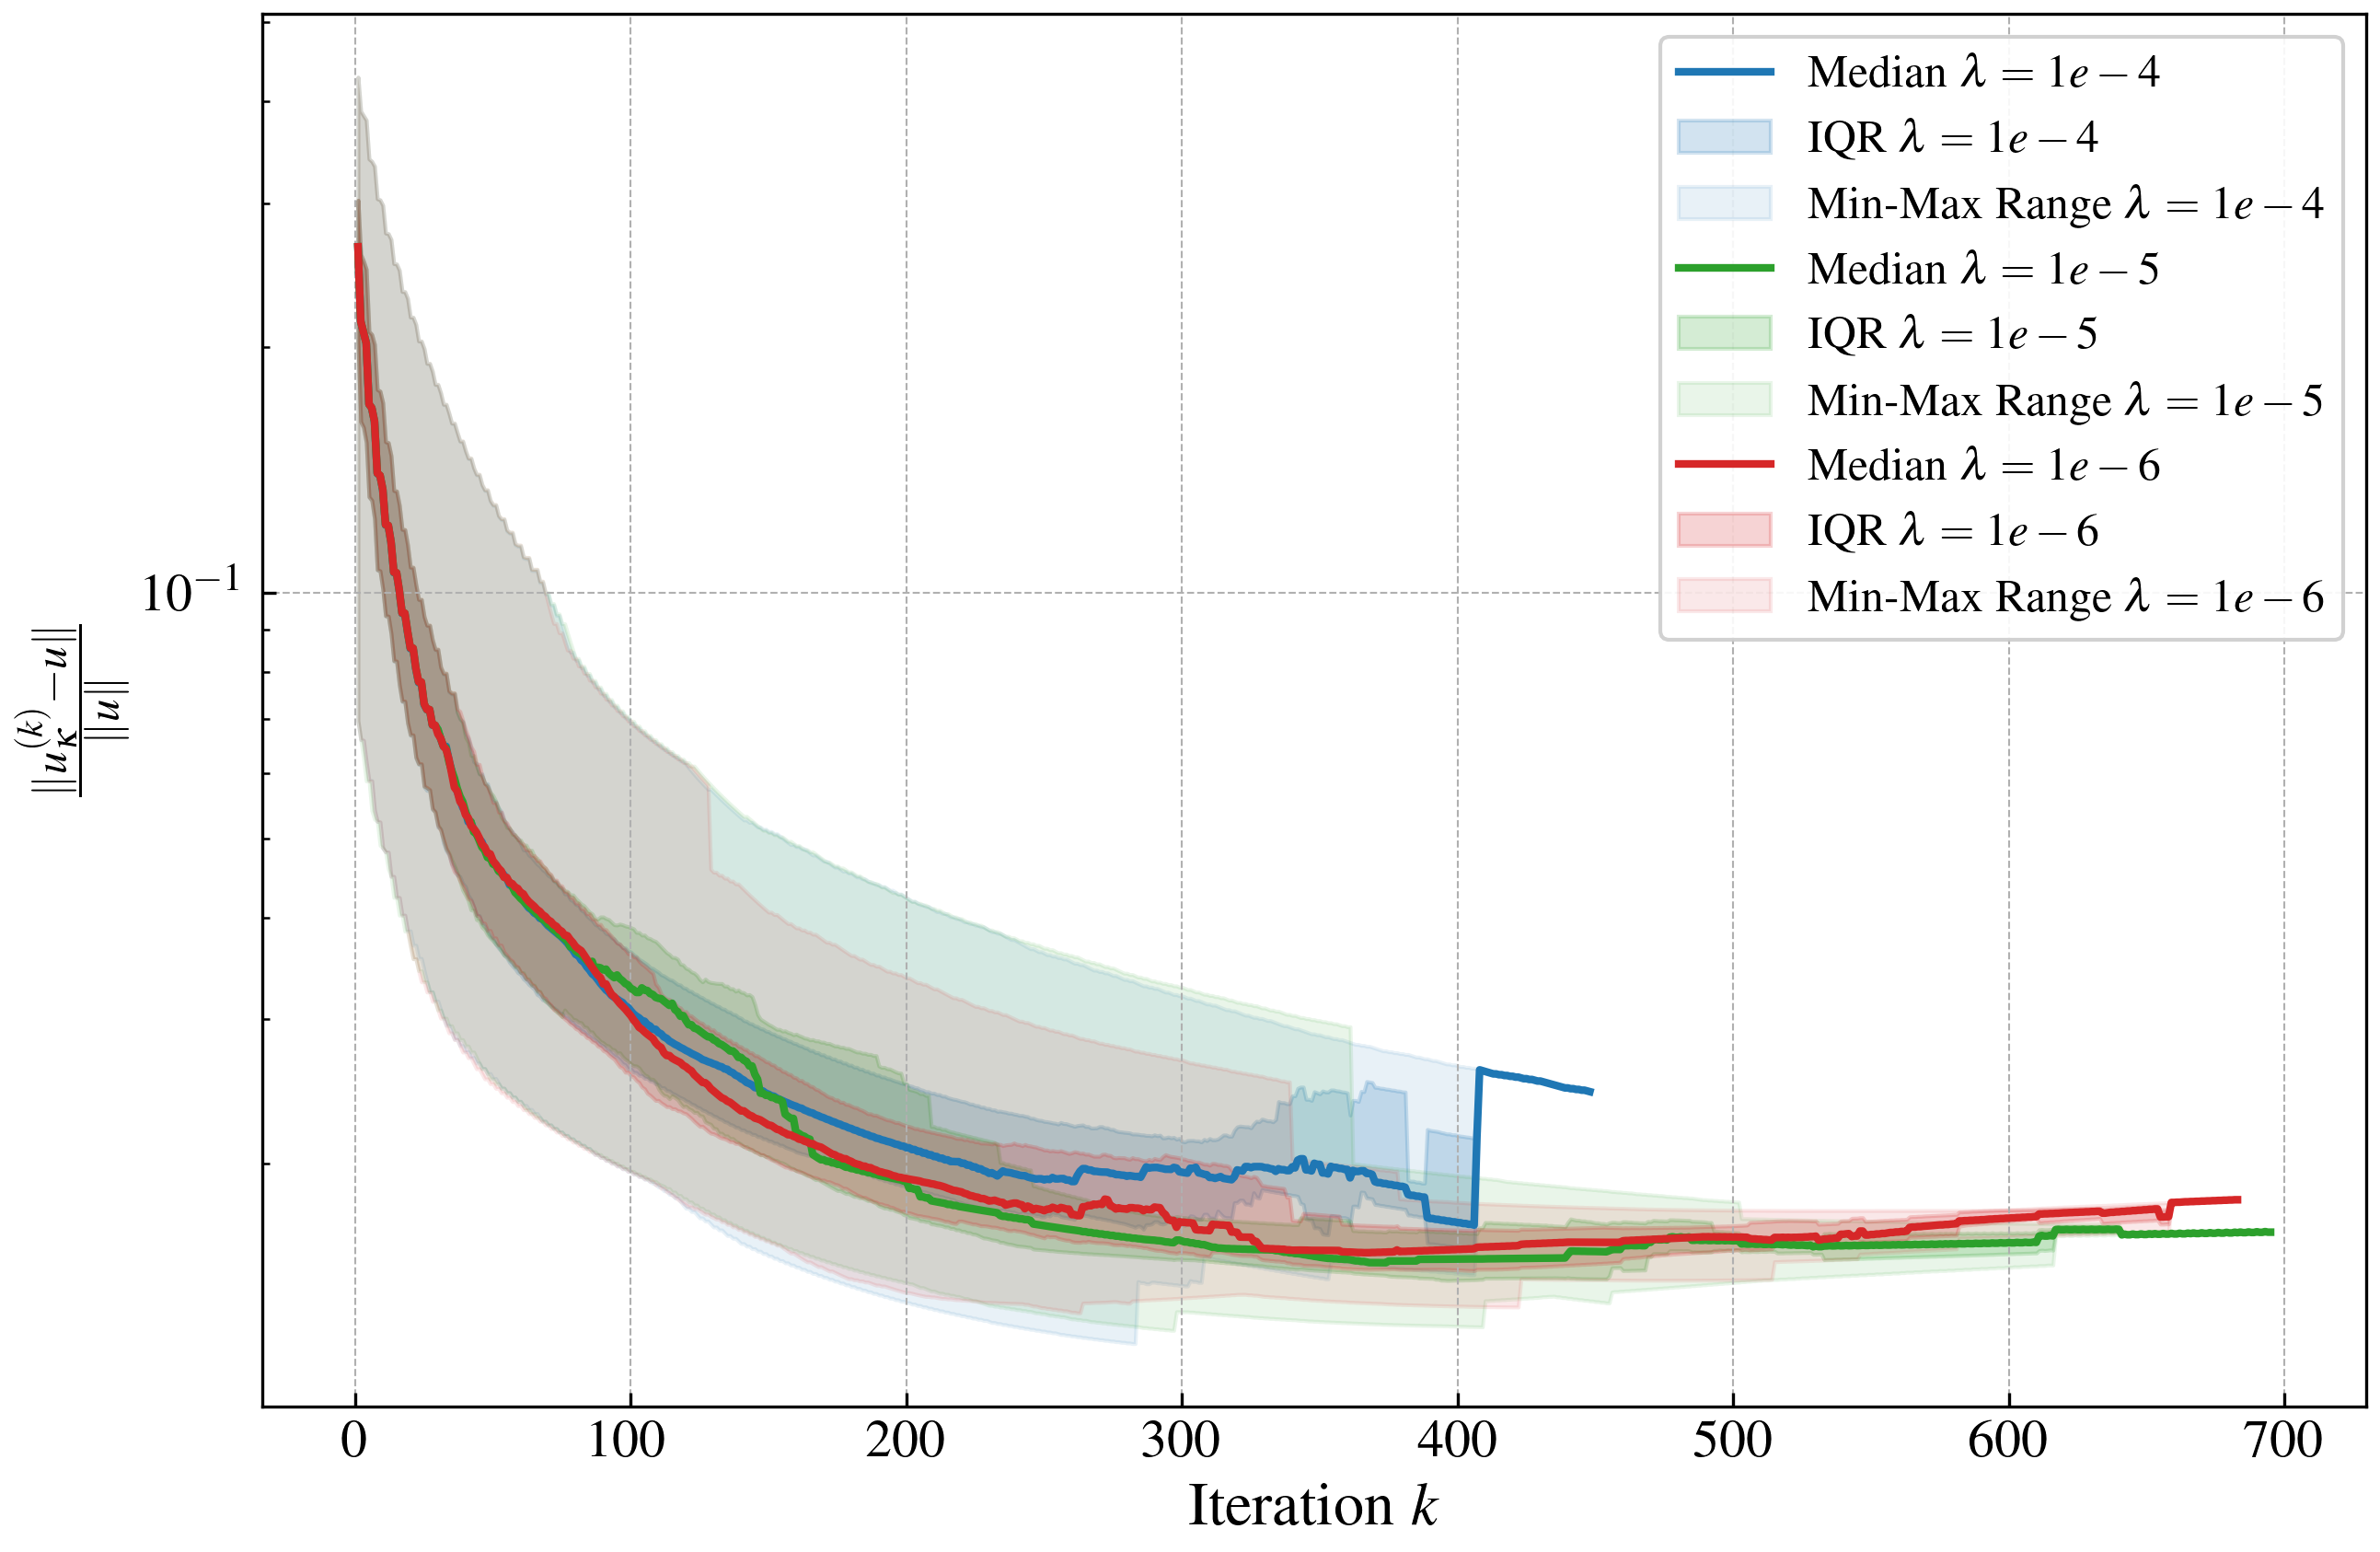

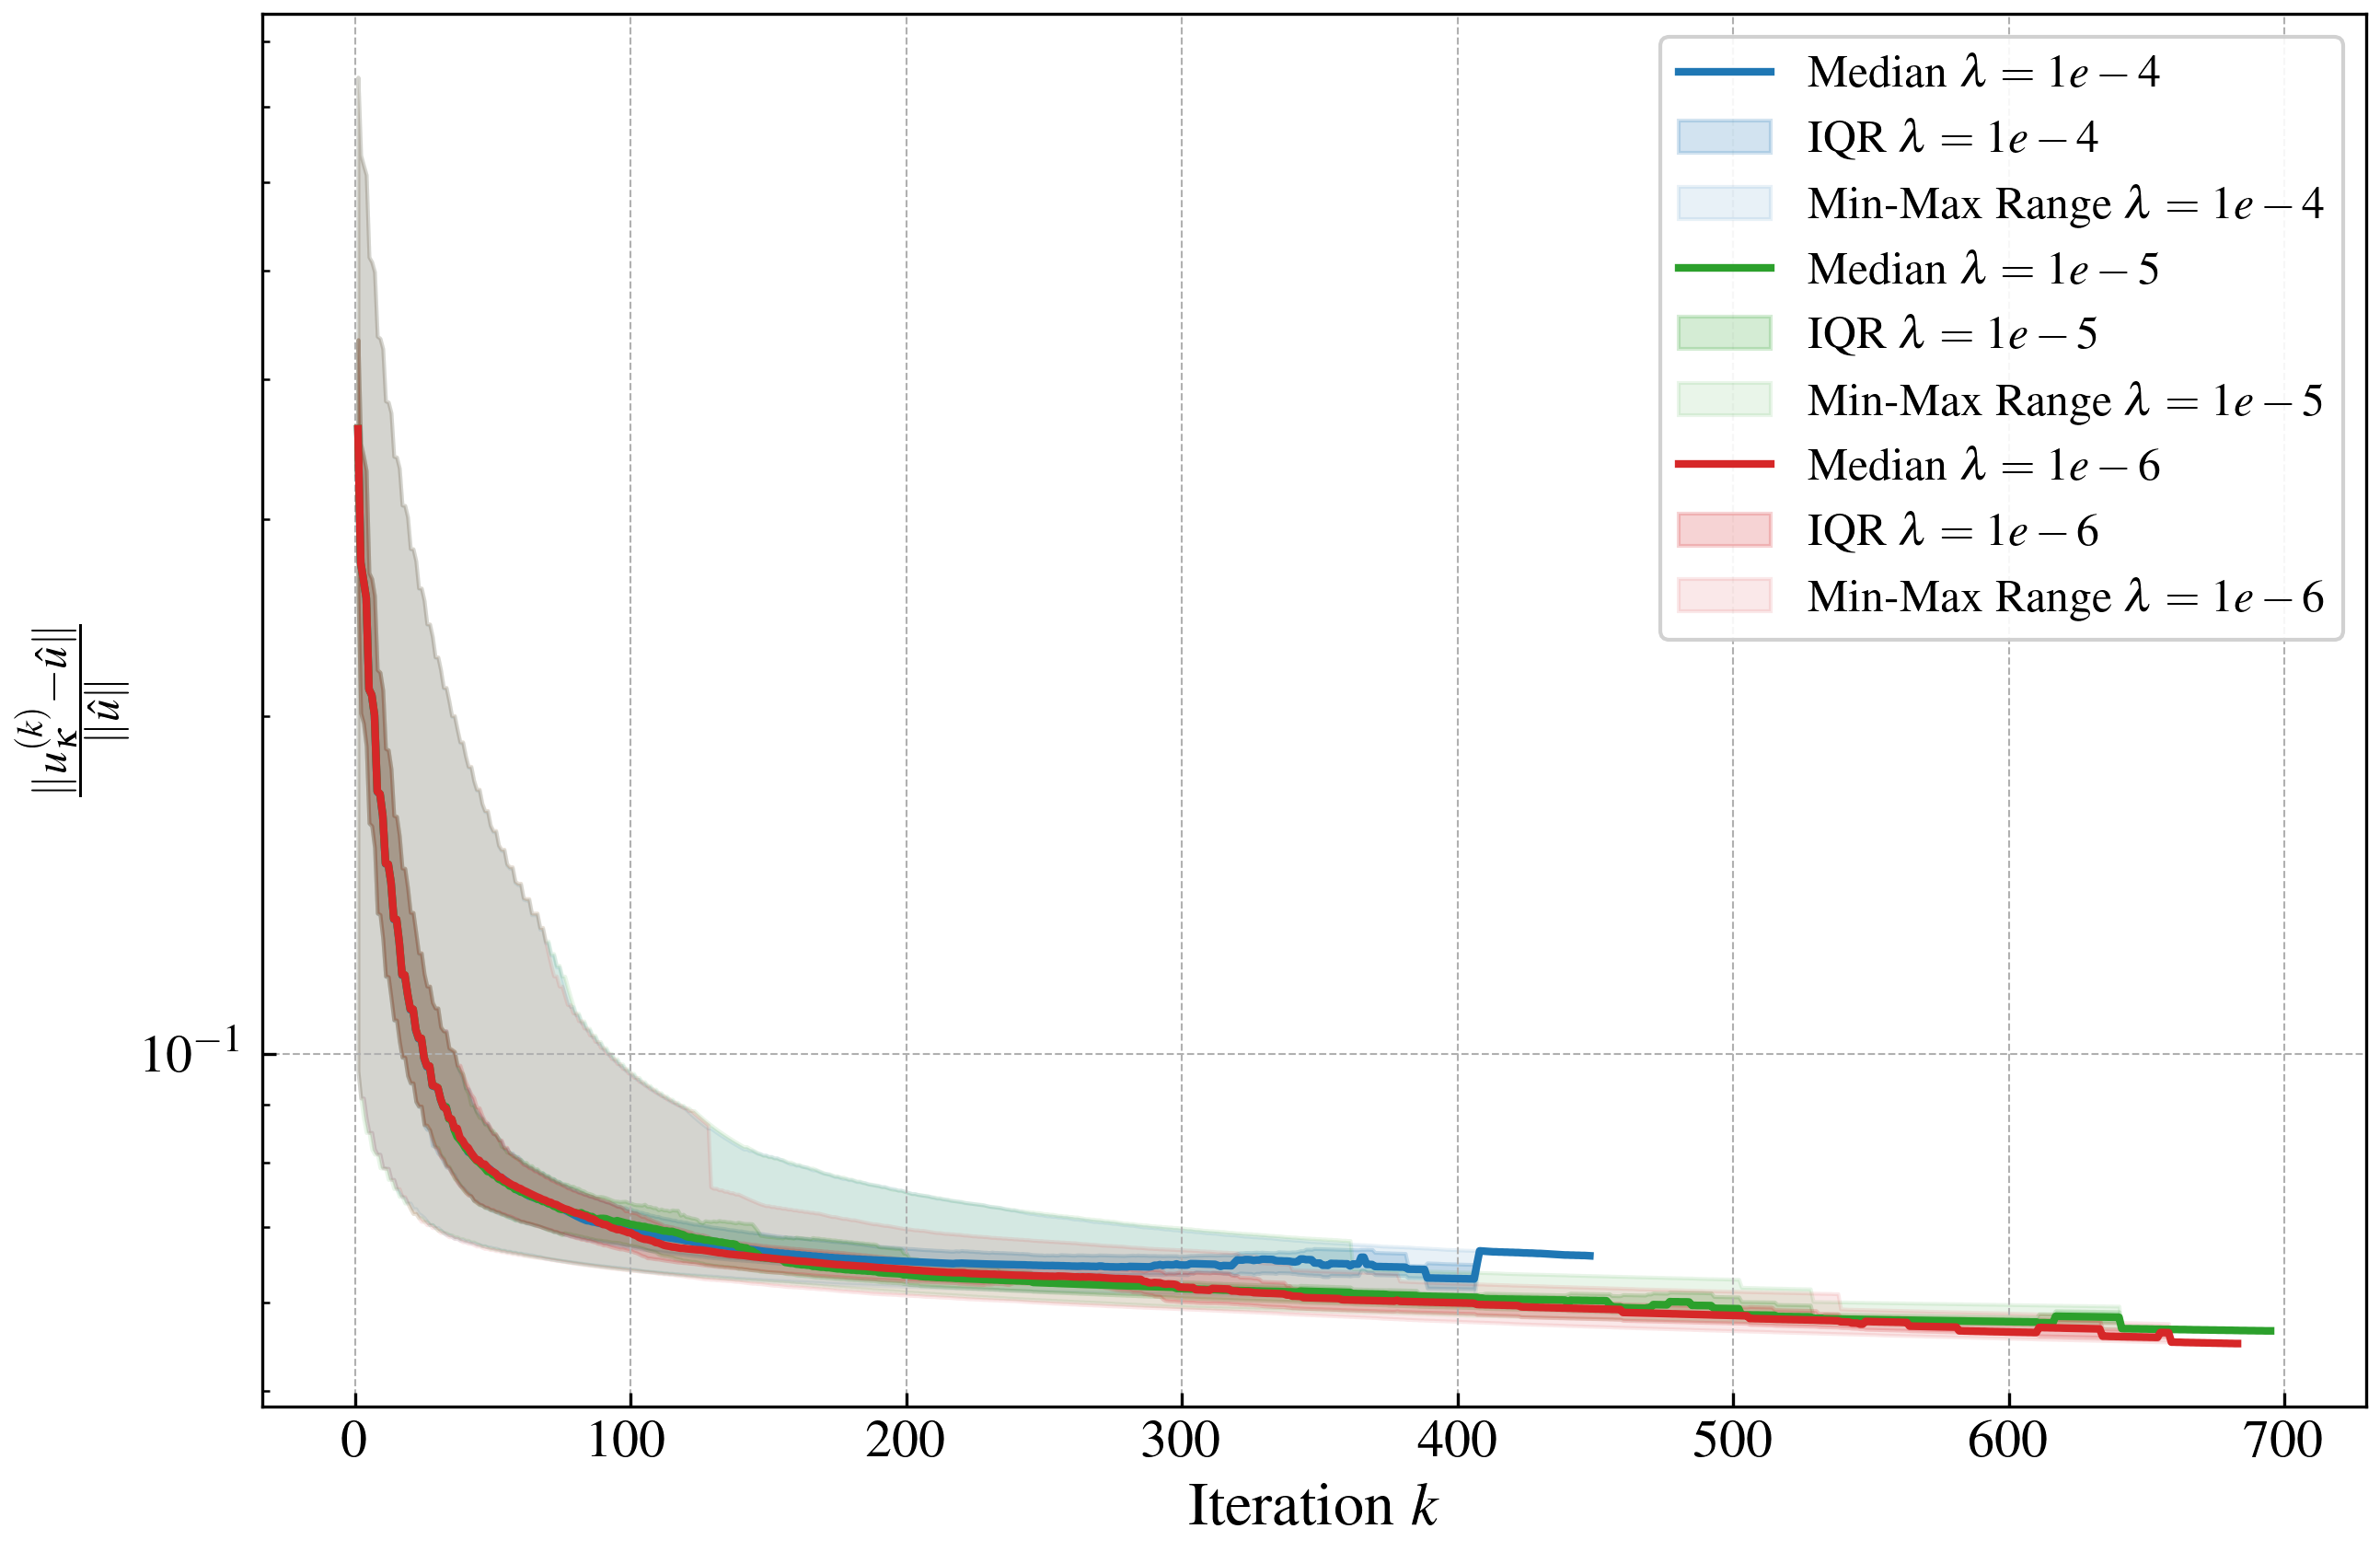

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
from pathlib import Path

# Setup for publication quality
mpl.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'figure.figsize': (9, 6),
    'figure.dpi': 300,
})

# Define the regularization strengths to compare
reg_strengths = ['1e-4', '1e-5', '1e-6']
colors = ['#1f77b4', '#2ca02c', '#d62728']  # Blue, Green, Red

# Load and process each result set
all_results = {}
for reg in reg_strengths:
    # Load each result file
    results_file = f"../results/analysis/results-denoiser-{reg}.npz"
    try:
        results = np.load(results_file, allow_pickle=True)
        # Process this result set using existing pipeline
        
        run_keys = list(results.keys())
        num_runs = len(run_keys)

        # --- 1. Data Extraction with Padding ---

        iterative_metrics = [
            "kappa_iterates_rel_errors",
            "ukappa_iterates_rel_errors",
            "ukappa_iterates_rel_errors_meas",
            "objectives",
            "reg_values", # Added reg_values 
        ]
        final_metrics = [
            "kappa_final_rel_error",
            "ukappa_recovered_rel_error",
            "ukappa_recovered_rel_error_meas",
            "total_optimization_time",
            "iterations",
        ]

        extracted_iterative = {metric: [] for metric in iterative_metrics}
        extracted_final = {metric: [] for metric in final_metrics}
        all_iteration_counts = []

        # First pass: Extract data and find max iterations
        max_iterations = 0
        for key in run_keys:
            try:
                # Use .item() to get the dictionary from the numpy scalar object
                run_data = results[key].item()
                if not isinstance(run_data, dict):
                    print(f"Warning: Item for key {key} is not a dict, skipping run.")
                    continue

                # Store actual iteration count for this run
                iterations_this_run = run_data.get("iterations")
                # Also check length of an iterative list as a fallback/consistency check
                iter_list_len = len(run_data.get("kappa_iterates_rel_errors", []))

                if iterations_this_run is None:
                    iterations_this_run = iter_list_len # Fallback if 'iterations' key missing
                    if iter_list_len == 0 and "objectives" in run_data: # Another fallback
                        iterations_this_run = len(run_data.get("objectives", []))

                if iterations_this_run is not None and iterations_this_run > 0:
                    all_iteration_counts.append(iterations_this_run)
                    max_iterations = max(max_iterations, iterations_this_run)
                else:
                    print(f"Warning: Could not determine iteration count for run {key}. Skipping.")
                    continue # Skip run if we can't determine iterations

                # Store iterative data for now (will pad later)
                for metric in iterative_metrics:
                    if metric in run_data:
                        extracted_iterative[metric].append(list(run_data[metric])) # Store as list for now
                    else:
                        # Placeholder indicating metric was missing for this run
                        extracted_iterative[metric].append(None)

                # Store final data
                for metric in final_metrics:
                    if metric in run_data:
                        extracted_final[metric].append(run_data[metric])
                    else:
                        extracted_final[metric].append(np.nan)

            except Exception as e:
                print(f"Error processing run {key}: {e}. Skipping run.")
                # Ensure lists in extracted_iterative maintain correspondence if skipping
                for metric in iterative_metrics:
                    # Check if we already added placeholder/data for this key in this loop iteration
                    if len(extracted_iterative.get(metric, [])) < len(all_iteration_counts) + (1 if 'iterations_this_run' in locals() and iterations_this_run is not None and iterations_this_run>0 else 0) :
                        extracted_iterative[metric].append(None) # Add placeholder if needed


        # Check if we found any valid runs
        if max_iterations == 0:
            print("Error: No valid runs found or max_iterations is zero. Cannot proceed with plotting.")
        else:
            print(f"Found {len(all_iteration_counts)} runs with valid iteration counts. Max iterations: {max_iterations}")
            iterations_axis = np.arange(1, max_iterations + 1)

            # Second pass: Pad iterative data and convert to numpy arrays
            padded_iterative_arrays = {}
            for metric in iterative_metrics:
                padded_data = []
                run_index = 0 # Keep track of which run we are processing
                for i, data_list in enumerate(extracted_iterative[metric]):
                    # Find corresponding iteration count for this run's data
                    # This assumes the order in extracted_iterative[metric] matches the order runs were successfully processed in the first loop
                    if data_list is not None: # Check if metric existed for this run
                        current_run_iterations = all_iteration_counts[run_index]
                        # Pad with NaNs if shorter than max_iterations
                        padding_needed = max_iterations - current_run_iterations
                        if padding_needed > 0:
                            padded_list = data_list + [np.nan] * padding_needed
                        else:
                            # Truncate if longer (shouldn't happen if max_iterations is correct, but safe)
                            padded_list = data_list[:max_iterations]

                        # Ensure final list has exactly max_iterations length
                        if len(padded_list) != max_iterations:
                            # This might happen if data_list was unexpectedly longer than 'iterations' reported
                            print(f"Warning: Length mismatch for metric '{metric}' in run {run_keys[i]}. Adjusting length.")
                            if len(padded_list) > max_iterations:
                                padded_list = padded_list[:max_iterations]
                            else: # Pad if still too short
                                padded_list = padded_list + [np.nan] * (max_iterations - len(padded_list))

                        padded_data.append(padded_list)
                        run_index += 1
                    else:
                        # If metric was missing for the run, add a list of NaNs
                        padded_data.append([np.nan] * max_iterations)
                        # We still need to increment run_index IF the run itself was valid (had iterations)
                        # Check if the overall index 'i' corresponds to a valid run index
                        if i < len(all_iteration_counts): # Safety check
                            run_index += 1


                if padded_data: # Only add if we collected some data
                    padded_iterative_arrays[metric] = np.array(padded_data, dtype=np.float64) # Use float64 for NaNs
        
        all_results[reg] = {
            'data': padded_iterative_arrays,
            'iterations_axis': iterations_axis,
            'num_runs': len(all_iteration_counts)
        }
    except Exception as e:
        print(f"Error loading {results_file}: {e}")

# Key metrics to compare across regularization strengths
comparison_metrics = [
    {
        "metric": "kappa_iterates_rel_errors",
        "ylabel": r"$\frac{\|\kappa^{(k)} - \kappa\|}{\|\kappa\|}$",
        "filename": "../figures/comparison/kappa_error_comparison.pdf"
    },
    {
        "metric": "ukappa_iterates_rel_errors",
        "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - u\|}{\|u\|}$",
        "filename": "../figures/comparison/solution_error_true_comparison.pdf"
    },
    {
        "metric": "ukappa_iterates_rel_errors_meas",
        "ylabel": r"$\frac{\|u_{\kappa}^{(k)} - \hat{u}\|}{\|\hat{u}\|}$",
        "filename": "../figures/comparison/solution_error_measured_comparison.pdf"
    }
]

# Create comparison plots
for config in comparison_metrics:
    metric = config["metric"]
    
    fig, ax = plt.figure(), plt.gca()
    
    # Plot each regularization strength
    for i, reg in enumerate(reg_strengths):
        if reg not in all_results or metric not in all_results[reg]['data']:
            print(f"Skipping {reg} for {metric}: Not found in data")
            continue
            
        result = all_results[reg]
        data_array = result['data'][metric]
        valid_mask = ~np.all(np.isnan(data_array), axis=0)
        iterations = result['iterations_axis'][valid_mask]
        
        # Calculate median values
        median_vals = np.nanmedian(data_array[:, valid_mask], axis=0)
        
        # Plot median line 
        ax.plot(iterations, median_vals, '-', color=colors[i], linewidth=2,
                label=f"Median $\lambda = {reg}$")
        
        # Plot quartiles
        q1_vals = np.nanpercentile(data_array[:, valid_mask], 25, axis=0)
        q3_vals = np.nanpercentile(data_array[:, valid_mask], 75, axis=0)
        ax.fill_between(iterations, q1_vals, q3_vals, color=colors[i], alpha=0.2,
                        label=f"IQR $\lambda = {reg}$")
        # Plot min-max range
        min_vals = np.nanmin(data_array[:, valid_mask], axis=0)
        max_vals = np.nanmax(data_array[:, valid_mask], axis=0)
        ax.fill_between(iterations, min_vals, max_vals, color=colors[i], alpha=0.1,
                        label=f"Min-Max Range $\lambda = {reg}$")
    
    # Set labels and styling
    ax.set_xlabel('Iteration $k$')
    ax.set_ylabel(config["ylabel"])
    if 'error' in metric.lower():
        ax.set_yscale('log')
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.legend(loc='best', framealpha=0.9, fontsize=12)
    ax.tick_params(direction='in', which='both')
    
    plt.tight_layout()
    
    # Save figure
    savepath = Path(config["filename"])
    if not savepath.parent.exists():
        os.makedirs(savepath.parent, exist_ok=True)
    plt.savefig(savepath)
    
    plt.show()